<a href="https://colab.research.google.com/github/ankurmahesh/ai4ess-hackathon-2020/blob/master/notebooks/seasonal_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI for Earth System Science Hackathon 2020: Seasonal Forecasting**

Ankur Mahesh (ClimateAi)

## Introduction


El Niño/ Southern Oscillation (ENSO) is the dominant mode of variability that affects the climate on seasonal time scales.  It is measured by the Nino3.4 index, a rolling 3-month average of equatorial Pacific temperatures.  ENSO is an oscillation and is marked by two phases: El Niño, with anomalously warm equatorial Pacific temperatures, and La Niña, with anomlously cold temperatures.  Because El Niño is tied to many weather patterns around the world, such as the Indian monsoon, hurricanes in the Atlantic, and North American temperature, accurate ENSO forecasts are valuable for climate-sensitive sectors (such as agriculture, water, and energy).

Existing El Niño forecasts utilize dynamical models, from the European Center for Medium-range Weather Forecasts and the National Center for Environmental Prediction. These dynamical models issue forecasts by modeling the physics of the atmosphere and ocean.  In this notebook, we will issue ENSO forecasts using machine learning, which uses statistical optimization to issue forecasts.






## Software Requirements

This notebook requires the following libraries: numpy, xarray, netCDF4, pandas, matplotlib, sklearn, tqdm, pytorch, scipy.  Furthermore, it is *strongly* recommended that you use this notebook on Google Colab for ease of use and for access to GPU resources.

In [20]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Data



*   [Cobe Sea-Surface Temperature Dataset:](https://psl.noaa.gov/data/gridded/data.cobe.html): this is a dataset of historical sea surface temperatures form 1880 to 2018
*   [Nino3.4 Indices](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/): The Nino3.4 index measures the 3-month rolling average of equatorial Pacific Ocean temperature anomalies.
*   CNRM-CM5 pre-industrial control run climate model surface temperature
*   Max Planck Institute CMIP5 pre-industrial control run surface temperature

More information about the climate models can be found [here](https://esgf-node.llnl.gov/projects/cmip5/).

The pre-industrial control runs are climate model scenarios that assume that there are no anthropogenic emissions. The reason that we use the "pre-industrial control" run of the climate models as opposed to the historical runs is that the former runs are far longer, allowing us to have more data for neural network training.




### Input Variables

Sea surface temperature (K)

### Output Variables

Nino3.4 index (K): this metric indicates the state of ENSO.



### Training Set

Baseline training set: Training on **1980-1995 sea Surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 months)

Throughout the hackathon, we will explore the effect of adding additional data, such as data from the CNRM-CM5 and MPI general circulation models.


### Test Set
**1997-2006 sea surface temperatures** and their corresponding Nino3.4 Index at lead times.

### Test Set: 

Test on **2007-2017 sea surface temperatures** and their corresponding Nino3.4 Index at lead times (1 month to 5 month).

In [2]:
#Download the required packages and the data that we will use 
#for this tutorial

!pip install netCDF4
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt
!wget http://portal.nersc.gov/project/dasrepo/AMS_ML_Tutorial/MPI_tas_anomalies_regridded.nc
!wget http://portal.nersc.gov/project/dasrepo/AMS_ML_Tutorial/CNRM_tas_anomalies_regridded.nc

--2020-06-23 19:16:25--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.201.128
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2020-06-23 19:16:25--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc.1’

sst.mon.mean.trefad 100%[===================>] 412.45M  59.1MB/s    in 7.1s    

2020-06-23 19:16:32 (57.9 MB/s) - ‘sst.mon.mean.trefadj.anom.1880to2018.nc.1’ saved [432481041/432481041]

--2020

In [24]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time, 
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date 
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]
  
  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead, 
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


In [4]:
# Sample loading of train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=1)
X_val, y_val = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=1)


NameError: name 'xr' is not defined

# Baseline Machine Learning Model


The baseline ML model will be linear regression.



RMSE: 0.28


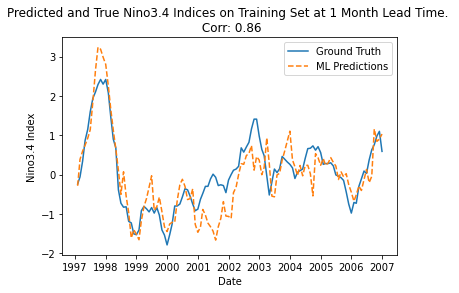

In [5]:

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions = regr.predict(X_val)
corr, _ = scipy.stats.pearsonr(predictions, y_val)
rmse = mean_squared_error(y_val, predictions)
print("RMSE: {:.2f}".format(rmse))

plot_nino_time_series(y_val, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 1 Month Lead Time. \n Corr: {:.2f}'.format(corr))

## Metrics

The metrics for evaluating an ML model are 

Pearson correlation, 

*  Pearson correlation
*   RMSE

The above code snippet includes examples of calculating them.

## Key Terms



Some terms:
*   predictor     : the input to a machine learning model: a certain number of months (that you define) of gridded temperature)
*   predictand    : the true value the model is trying to predict (i.e. the true Niño3.4 index)
*   prediction    : the output of the machine learning model



# Monday

## Train/Val/Test Set and Overfitting

A machine learning model uses statistical optimization to learn the relationship between predictors (the input) and predictands (the target).  
*   At this workshop, our predictors have been anomalized global temperature, and our predictand has been the El Nino/ Southern Oscillation (ENSO) 3.4 Index at a lead time.  

Let's call our predictors $X$, and let's call our predictand $y$.  There is some unknown relationship between $X$ and $y$.  For example, there is some unknown function governing the relationship between global temperature and the future ENSO index.  The goal of an ML model is to *approximate* this unknown function.

How do we test if the ML model has correctly approximated this function?  We divide the data into a train set and a test set.


*   During training, the ML model is shown the predictors and their associated predictands.  The ML model uses optimization to learn a function: given the training predictors, the function outputs the predictands as closely as possible.
*   During testing, the ML model is evaluated on unseen data (i.e. the test set). When a model performs well on the training set and poorly on the test, the model has **overfit** to the train set.
*   If a model performs poorly on the training set, this behavior is called **underfitting**.  During underfitting, the model has not learned the correct relationship between the predictors and the predictand.



***Question***: In the image below, which image corresponds to overfitting? Which corresponds to underfitting? And which corresponds to neither?


![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)




In the next code cell, let's study overfitting in the following task: training a machine learning model to forecast El Niño.  El Niño is a cycle of warm and cold temperatures in the equatorial Pacific Ocean that has broad implications for seasonal weather.

The code cell below demonstrates overfitting: getting great performance on the train set.
For an absurd lead time (36 months!!), it is possible to get a perfect correlation on the train set.  Such accurate forecasting at such large lead times is almost certainly impossible.


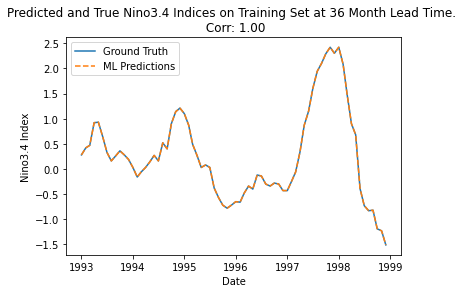

In [6]:
#Load in the predictors
X, y = assemble_basic_predictors_predictands('1990-01-01','1995-12-31', 36)

#Let's use a linear regression model
regr = sklearn.linear_model.LinearRegression()
regr.fit(X,y)

predictions = regr.predict(X)
corr, _ = scipy.stats.pearsonr(predictions, y)

plot_nino_time_series(y, predictions, 
    'Predicted and True Nino3.4 Indices on Training Set at 36 Month Lead Time. \n Corr: {:.2f}'.format(corr))

The cell above shows that getting great train-set performance is possible, even for a very tough task (36 month ahead Nino forecast).
We need to evaluate the model on unseen data to see if it can **generalize** well: this is why a test set is so crucial!


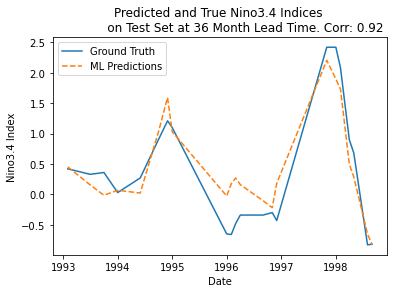

In [7]:
"""Evaluate the model on a randomly selected test set"""
#X has shape (num_time_steps, lat*lon)
#y has shape (num_time_steps)
np.random.seed(0)

#Randomly shuffle X and y to split them in a train and test set
num_time_steps = X.shape[0]
permuted_indices = np.random.permutation(np.arange(num_time_steps))

#Keep 70% of the data for the test set
train_set_proportion = int(0.7 * num_time_steps)
X, y = X[permuted_indices], y[permuted_indices]
X_train, y_train = X[:train_set_proportion], y[:train_set_proportion]
X_test, y_test = X[train_set_proportion:], y[train_set_proportion:]

#Instead of writing the above logic yourself, sklearn also provides
#a built-in method in the line below.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_train,y_train)

predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

What happened above? Did we just develop a 36-month ahead forecast that has 0.81 correlation on unseen data??

Randomly splitting time series data into a train set and a test set is very risky. In many climate datasets, time series have a non-neglible auto-correlation.  Think of it like this: the atmosphere usually has a "memory" of about 14 days, and the ocean roughly has a "memory" of about 2 years.  

If we randomly split the dataset into train set and test set, some of the examples in the test set will be correlated with examples in the train set.  **This corrupts our test set.** If the test set is correlated with the train set, then it no longer measures how generalizable our ML model is.

**CODING EXERCISE** In the cell below, write code to evaluate the model on a true uncorrelated test set.

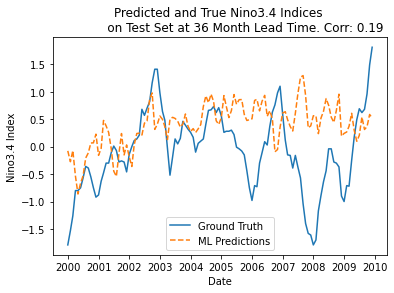

In [81]:
"""YOUR CODE HERE"""
X_test, y_test = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=36)
predictions_test = regr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)

plot_nino_time_series(y_test, predictions_test,
            'Predicted and True Nino3.4 Indices \n \
            on Test Set at 36 Month Lead Time. Corr: {:.2f}'.format(corr))

After your work on the previous exercise, check your understanding.  On a true test set, does the model making *36 month ahead* predictions generalize well?

***CODING EXERCISE*** Using the code samples above as a starting point, in the following cell, write code to calculate and plot the performance of the model at different lead times.

In [82]:
corr_lead=[]
for i in range(37):
    X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=i)
    X_test, y_test = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=i)

    regr = sklearn.linear_model.LinearRegression()
    regr.fit(X_train,y_train)

    predictions_test = regr.predict(X_test)
    corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
    corr_lead.append(corr)
    

Text(0.5, 1.0, 'Correlation between predicted and actual Nino3.4')

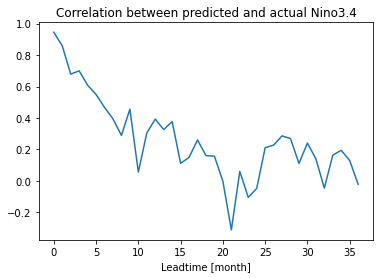

In [83]:
plt.plot(range(37),corr_lead)
plt.xlabel('Leadtime [month]')
plt.title('Correlation between predicted and actual Nino3.4')

***CODING EXERCISE*** Calculate and plot the performance of the model with different size training datasets

In [91]:
"""YOUR CODE HERE"""
corr_lead_train=[]

for i in range(37):
    X_test, y_test = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=i)
    for p in np.arange(0.1,1.0,0.1):
        X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=i)
        X_train, _ , y_train, _ = train_test_split(X_train, y_train, train_size=p, random_state=0, )
        
        regr = sklearn.linear_model.LinearRegression()
        regr.fit(X_train,y_train)

        predictions_test = regr.predict(X_test)
        corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
        corr_lead_train.append(corr)

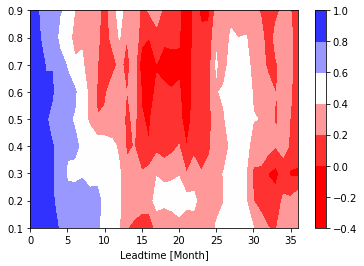

In [112]:
plt.contourf(range(37),np.arange(0.1,1.0,0.1),
             np.array(corr_lead_train).reshape(37,9).T,
             cmap='bwr_r', vmax=1,vmin=0)
plt.xlabel('Leadtime [Month]')
plt.colorbar()

## Monday: The Bias-Variance Tradeoff

### Introduction and Theory

The behavior of machine learning models can be decomposed into two quantities:

*   **Bias**: On the training set, how well does the machine learning model predict the truth?
*   **Variance**: As the input data varies, how does the machine learning prediction vary?  For a small change in the input predictors, how much would the ML prediction change? 

Let's look at the earlier figure once again:
![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_underfitting_overfitting_001.png)


The left image uses a linear model to approximate a nonlinear "true function".  Therefore, the linear model does not understand the function well, and it has high bias.  Similarly, it has low variance, because small changes to sample points along the curve will not change the linear model must.


***Question*** 
1. Does the right image have high or low bias?
2. Does the right image have high or low variance?


Based on the figures above, we conclude that bias and variance are often a tradeoff: models with high bias often have low variance, and vice versa.  See page 23 of Nasiriany's notes for a mathematical derivation of this tradeoff.


Here's another example to help develop our visual understanding of bias vs. variance.

Here is how a k-Nearest-Neighbor model works:
1. The model is shown a sample data point from the test set, $x_\text{test}$
2. It searches its training set for the $k$ most similar data points
3. Of the $k$ points it founds, it calculates the most common predictand, and it assigns $x_\text{test}$ the most common 

Crucially, this method supports classification of data that is not linearly separable (see below image for an example)

***Polling question:*** For different values of $k$, would you expect a high bias/low variance classifier? Or a high variance/low bias classifier?

![alt text](https://cse3521.artifice.cc/images/effect-of-k.png)




Let's connect the bias/variance tradeoff to the discussion we had on overfitting in the first section. Implications of the bias-variance tradeoff (from Wikipedia)
 
*   "The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (**underfitting**)."

*   "The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (**overfitting**)."

### Regularization

Our goal in machine learning is to avoid underfitting and overfitting: we want to develop models that perform well in both the train set and the test set.

One method to avoid overfitting is **regularization.** In the next section, we will discuss how regularization avoids overfitting.  

Let $X$ be a 2D matrix of shape $(n,d)$ where $n$ is the number of time steps and $d$ is the number of predictors.  Let $y$ be a vector of shape $(n,1)$ that has the target ENSO values.  Let $w$ be a vector of shape $(d,1)$

In ordinary least squares linear regression, we are **finding the value of $w$** that minimizes the following term: 

$$\text{min}||Xw-y||^2 $$


Here's an intuitive description of the math above: 
*   the goal of linear regression is to minimize the squared difference between the linear models' predictions ($Xw$) and the truth ($y$).

The forecast of a linear regression model is $Xw$.  Here's an intuitive description of what $Xw$: 
*   a linear regression model makes a forecast by multiplying each predictor by its associated weight and returning the sum of these products. With  large weights, a small change in one of the predictors will lead to a large change in the forecast.  Therefore, we amend linear regression to penalize the model from learning large weights:


$$\text{min}||Xw-y||^2 + \alpha ||w||^2 $$


$\alpha ||w||^2$ is called a regularization term. This regularized form of linear regression is often called **Ridge Regression**.

Please see pg. 6 of Nasiriany for mathematical derivations to the solutions of the above two minimization problems.


### *Coding Exercise*: Regularization


In this example, we will investigate the real-world effect of regularization on our ENSO dataset. 

Note: for visualization purposes, we do not train our models using all lat$*$lon predictors.  Instead, we use Principal Components Analysis (aka Empirical Orthogonal Functionals) to represent all lat$*$lon predictors with far fewer dimensions.  Due to time constraints, please refer to page 116 of Professor Shewchuk's notes for a deeper explanation of this method.

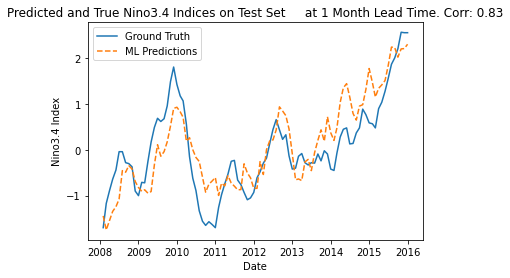

In [13]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31', 
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_lr.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


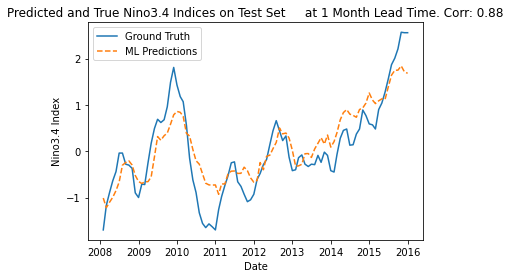

In [14]:
X_train, y_train = assemble_basic_predictors_predictands('1990-01-01','2005-12-31', 
                                                1,use_pca=True)
X_test, y_test = assemble_basic_predictors_predictands('2008-01-01','2015-12-31', 1,
                                                  use_pca=True)
regr_1_month_ridge = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_ridge.fit(X_train,y_train)

#First, let's plot the performance of the model
predictions_test = regr_1_month_ridge.predict(X_test)
corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
plot_nino_time_series(y_test, predictions_test,
    'Predicted and True Nino3.4 Indices on Test Set \
    at 1 Month Lead Time. Corr: {:.2f}'.format(corr))


On the test set we see that the regularized model performs slightly better than the linear model! This is a good sign, as the goal of regularization is to develop models that can better **generalize** to unseen data.

Next, let's visualize and compare the variance of the two models.  Recall that models that are highly variable are susceptable to small fluctuations in the predictors.  In the code cell below, we conduct the experiment:


*   Perturb the test set predictors by multiplying them by a random number between -1.05 and 1.05
*   Run the trained ridge regression and linear regression models on those perturbed predictors
*   Record the spread in the predictions

The spread of these predictions is the variance of the ML model.

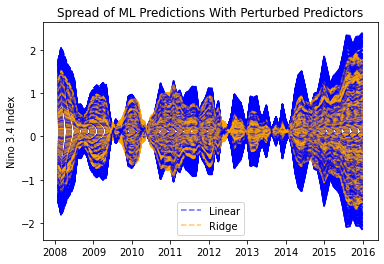

In [15]:
"""In this cell, we will visualize the variance of linear regression and ridge regression"""
for experiment_num in range(1000):
  perturbed_X_test = X_test * np.random.uniform(-1.05,1.05)
  
  perturbed_predictions_linear = regr_1_month_lr.predict(perturbed_X_test)
  perturbed_predictions_linear = pd.Series(perturbed_predictions_linear,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_linear, '--', label='Linear', color='blue',
           alpha=0.6)

  perturbed_predictions_ridge = regr_1_month_ridge.predict(perturbed_X_test)
  perturbed_predictions_ridge = pd.Series(perturbed_predictions_ridge,
                                           index=y_test.index)
  plt.plot(perturbed_predictions_ridge, '--', label='Ridge', color='orange',
           alpha=0.6)

  if experiment_num == 0: plt.legend(loc='best')

plt.title("Spread of ML Predictions With Perturbed Predictors")
plt.ylabel("Nino 3.4 Index")
plt.show()

The plot above illustrates the effect of regularization!  When randomly perturbing the input 1000 times, the predictions from linear regression (blue) have a larger spread than those from ridge regression (orange).  This means that linear regression has a higher variance than ridge regression.  

In the cell below, let's investigate why ridge regression is less vulnerable to small fluctuations in the data.

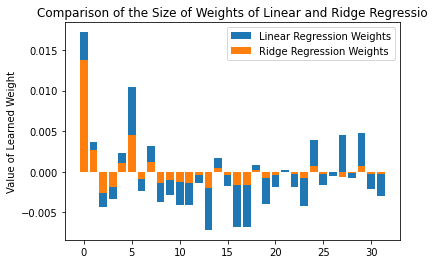

In [16]:
"""In this cell, we will visualize how the weights of the linear 
regression model are bigger than those of the ridge regression model"""

#coef_ loads in the coefficients from the trained model
regr_1_month_lr_weights = regr_1_month_lr.coef_
regr_1_month_ridge_weights = regr_1_month_ridge.coef_

plt.bar(range(regr_1_month_lr_weights.shape[0]), regr_1_month_lr_weights,
        label='Linear Regression Weights')
plt.bar(range(regr_1_month_ridge_weights.shape[0]), regr_1_month_ridge_weights,
        label='Ridge Regression Weights')
plt.legend(loc='best')
plt.ylabel('Value of Learned Weight')
plt.title('Comparison of the Size of Weights of Linear and Ridge Regressio')
plt.show()

As expected, the weights of the ridge regression model are smaller than those of the linear regression model. 

There we have it! On our real-world ENSO dataset, we have confirmed our theoretical speculations about the effect of regularization on the bias-variance tradeoff!  

To recap:

*   Because of the regularization term, the weights in a ridge regression model are smaller (large weights are penalized during the optimization) than those in linear regression
*   With smaller weights, the ridge regression model is less vulnerable to small fluctuations in the data
*   This means that ridge regression models have less variance and are less vulnerable to overfitting

## Machine Learning Models and Model Selection

### Variance Scaling

In the preprocessing presentation, we discussed ways that data is normalized before being fed into machine learning models.  Some models ML techniques require data to be centered (have mean 0); in other cases, normalization helps with numerical stability.  

One type of normalization is called variance scaling.  Variance scaling is to scale the variance of each predictor such that each predictor has a variance of 1.  

In our ENSO dataset, we have latxlon predictors; each predictor is temperature at a certain location on Earth.  We have ```num_time_steps``` samples of these predictors. Therefore, the shape of ```X``` is (num_time_steps, latxlon). *Variance scaling would mean that we scale our dataset such that the variance of temperature at each grid cell is 1.*

Should we use variance scaling for our ENSO forecasting model?

Acknowledgment: I'd like to  thank Professor [Patrick Brown](https://patricktbrown.org/about/) for helping me with this problem. 

In [102]:
"""Write code to explore the above question"""
corr_lead_train_norm=[]

for i in range(0,38,2):
    X_test, y_test = assemble_basic_predictors_predictands('1997-01-01','2006-12-31', lead_time=i)
    for p in np.arange(0.1,1.0,0.1):
        X_train, y_train = assemble_basic_predictors_predictands('1980-01-01','1995-12-31', lead_time=i)
        X_train, _ , y_train, _ = train_test_split(X_train, y_train, train_size=p, random_state=0, )
        
        # Not normalized
        regr = sklearn.linear_model.LinearRegression()
        regr.fit(X_train,y_train)

        predictions_test = regr.predict(X_test)
        corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
        corr_lead_train_norm.append(corr)
        
        # Normalized
        scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
        X_train = scaler.fit_transform(X_train)
    
        regr = sklearn.linear_model.LinearRegression()
        regr.fit(X_train,y_train)

        predictions_test = regr.predict(X_test)
        corr, _ = scipy.stats.pearsonr(predictions_test, y_test)
        corr_lead_train_norm.append(corr)



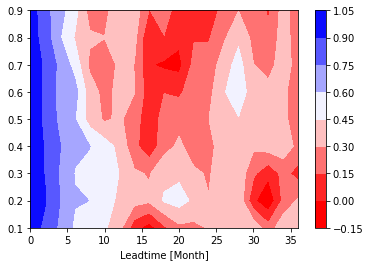

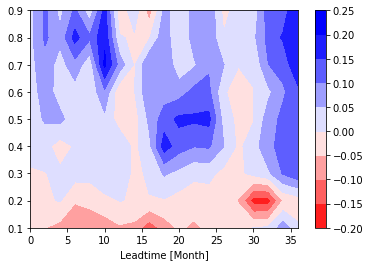

In [114]:
plt.contourf(range(0,38,2),np.arange(0.1,1.0,0.1),
             np.array(corr_lead_train_norm).reshape(19,9,2)[:,:,1].T,
             cmap='bwr_r', vmax=1,vmin=0)
plt.xlabel('Leadtime [Month]')
plt.colorbar()
plt.figure()
plt.contourf(range(0,38,2),np.arange(0.1,1.0,0.1),
             (np.array(corr_lead_train_norm).reshape(19,9,2)[:,:,1]-
              np.array(corr_lead_train_norm).reshape(19,9,2)[:,:,0]).T,
             cmap='bwr_r', vmax=0.2,vmin=-0.2)
plt.xlabel('Leadtime [Month]')
plt.colorbar()

### To regularize or not to regularize. That is the question.

# Tuesday

## Deep Learning

Now let's try training a neural network to forecast ENSO.  In this section, we will use PyTorch as our machine learning framework.



Let's get started: first, let's load the data.  **PLEASE READ THE DOCSTRING FOR THE `assemble_predictors_predictands` function!** It is essential to understand the arguments to this function as we explore different scientific/ machine learning questions later on in this hackathon.

In this section, the `assemble_predictors_predictands` method has been extended to load in data from observations AND from GCMs.

In [21]:
#Scaffold code to load in data.  This code cell is mostly data wrangling


def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time, 
                                    dataset, data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32,
                                    lat_slice=None, lon_slice=None):
  """
  inputs
  ------

      start_date           str : the start date from which to extract sst
      end_date             str : the end date 
      lead_time            str : the number of months between each sst
                              value and the target Nino3.4 Index
      dataset              str : 'observations' 'CNRM' or 'MPI'
      data_format          str : 'spatial' or 'flatten'. 'spatial' preserves
                                  the lat/lon dimensions and returns an 
                                  array of shape (num_samples, num_input_time_steps,
                                  lat, lon).  'flatten' returns an array of shape
                                  (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : the number of time steps to use for each 
                                 predictor sample
      use_pca             bool : whether or not to apply principal components
                              analysis to the sst field
      n_components         int : the number of components to use for PCA
      lat_slice           slice: the slice of latitudes to use 
      lon_slice           slice: the slice of longitudes to use

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies) 
      and the predictands (np array the ENSO index at the specified lead time).

  """
  file_name = {'observations' : 'sst.mon.mean.trefadj.anom.1880to2018.nc',
               'CNRM'         : 'CNRM_tas_anomalies_regridded.nc',
               'MPI'          : 'MPI_tas_anomalies_regridded.nc'}[dataset]
  variable_name = {'observations' : 'sst',
                   'CNRM'         : 'tas',
                   'MPI'          : 'tas'}[dataset]
  ds = xr.open_dataset(file_name)
  sst = ds[variable_name].sel(time=slice(start_date, end_date))
  if lat_slice is not None:
    """YOUR CODE HERE"""
    sst = sst.sel(lat=lat_slice)
    #raise NotImplementedError("In EXERCISE 7, you must implement the slicing!")
  if lon_slice is not None:
    """YOUR CODE HERE"""
    sst = sst.sel(lon=lon_slice)
    #raise NotImplementedError("In EXERCISE 7, you must implement the slicing!")
  
  
  num_samples = sst.shape[0]
  #sst is a (num_samples, lat, lon) array
  #the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  #CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)
    

    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  if dataset == 'observations':
    y = load_enso_indices()[slice(start_date_plus_lead, 
                                  end_date_plus_lead)]
  else: #the data is from a GCM
    X = X.astype(np.float32)
    #The Nino3.4 Index is composed of three month rolling values
    #Therefore, when calculating the Nino3.4 Index in a GCM
    #we have to extract the two months prior to the first target start date
    target_start_date_with_2_month = start_date_plus_lead - pd.DateOffset(months=2)
    subsetted_ds = ds[variable_name].sel(time=slice(target_start_date_with_2_month,
                                                   end_date_plus_lead))
    #Calculate the Nino3.4 index
    y = subsetted_ds.sel(lat=slice(5,-5), lon=slice(360-170,360-120)).mean(dim=('lat','lon'))

    y = pd.Series(y.values).rolling(window=3).mean()[2:].values
    y = y.astype(np.float32)
  ds.close()
  return X.astype(np.float32), y.astype(np.float32)


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

**IMPORTANT info about `num_input_time_steps`:** `num_input_time_steps` refers to the number of time steps for each predictor.  For example, if `num_input_time_steps` is set to 3, then the machine learning model will take 3 months as its input.  In other words, a sample predictor will be 3 months of average temperature: Jan average temperature, Feb average temperature, and March average temperature (i.e. an array of (3, lat, lon)).  The predictand will be the Niño3.4 index `lead_time` months after March.

Let's define a simple convolutional neural network to start.  


## Exercise 1: Train A Simple Convolutional Neural Network to Forecast ENSO


Let's define a simple convolutional neural network architecture.  This architecture has 1 convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers (called `nn.Linear` layers).  The output of the final fully connected layer is a 1-D array, since we are trying to forecast 1 value: the target ENSO index.



In [73]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()
        
        #ATTENTION EXERCISE 9: print out the dimension of the extracted features from 
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are 
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

Next, let's define a method that trains our neural network.  

**IMPORTANT** Reading through this method will help you understand each step in the process of training a neural network!

In [140]:
def train_network(net, criterion, optimizer, trainloader, testloader, 
                  experiment_name, num_epochs=40):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network 
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()

          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands)

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()
          
          #Save the model weights that have the best performance!
        

          running_loss += loss.item()
      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}.pt'.format(experiment_name))
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))
    
  net = torch.load('{}.pt'.format(experiment_name))
  net.eval()
  net.to(device)
  
  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()
    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions, train_losses, test_losses


In [75]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                  optimizer, trainloader, testloader, experiment_name)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 01. loss: 0.602908
test Set: Epoch 01. loss: 0.548869
train Set: Epoch 02. loss: 0.273814
test Set: Epoch 02. loss: 0.309938
train Set: Epoch 03. loss: 0.182280
test Set: Epoch 03. loss: 0.432283
train Set: Epoch 04. loss: 0.176100
test Set: Epoch 04. loss: 0.321123
train Set: Epoch 05. loss: 0.137806
test Set: Epoch 05. loss: 0.195962
train Set: Epoch 06. loss: 0.152096
test Set: Epoch 06. loss: 0.340334
train Set: Epoch 07. loss: 0.079607
test Set: Epoch 07. loss: 0.256380
train Set: Epoch 08. loss: 0.080029
test Set: Epoch 08. loss: 0.213145
train Set: Epoch 09. loss: 0.114351
test Set: Epoch 09. loss: 0.192604
train Set: Epoch 10. loss: 0.106585
test Set: Epoch 10. loss: 0.182277
train Set: Epoch 11. loss: 0.107746
test Set: Epoch 11. loss: 0.181676
train Set: Epoch 12. loss: 0.103924
test Set: Epoch 12. loss: 0.175407
train Set: Epoch 13. loss: 0.075755
test Set: Epoch 13. loss: 0.229384
train Set: Epoch 14. loss: 0.064993
test Set: Epoch 14. loss: 0.258163
train 

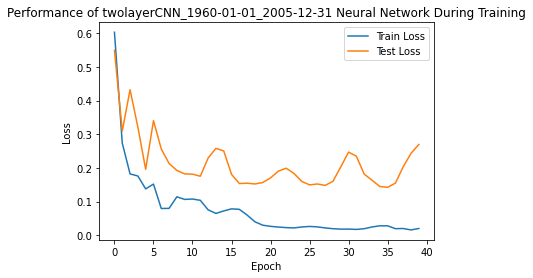

In [76]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

*Check your understanding:* From the previous section on fundamentals of machine learning, what is it called when the validation losses are very high and the train losses are very low?  What might we try to reduce this problem?

(Try reducing the number of parameters of the network -- see exercise 10!)

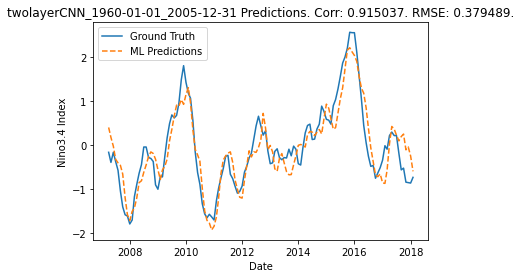

In [11]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(test_predictands, predictions, '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name,
                                                                      corr, rmse))

## Exercise 2: Forecast ENSO with Traditional Machine Learning using sklearn

Recall from the previous notebook that we used linear regression to forecast ENSO!  Try using other models for this task.  Explore the other models that sklearn has to offer, such as random forests!  Note: these traditional ML algorithms do not take advantage of the spatial nature of gridded datasets.  Therefore, they require the `data_format` argument to be set to 'flatten': the predictors are in the shape `(num_samples,lat*lon*num_time_steps)`.

**GOAL OF THIS EXERCISE:** try exploring the performance of other algorithms in the sklearn suite.  Try changing the lead_time in the `assemble_predictors_predictands` method (it is set to 1 initially).  How do the models perform?

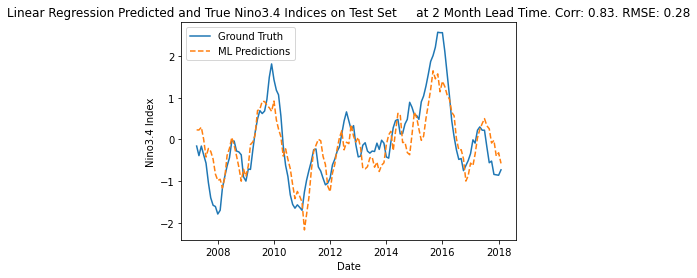

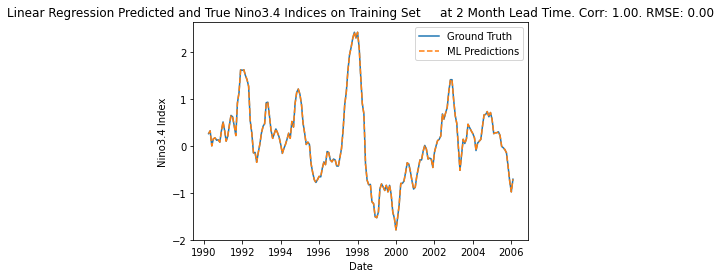

In [42]:
"""Plot the performance of linear regression at 1 month ahead lead time"""
#1 month linear regression (lr) model
train_start_date = '1990-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2 #change this and explore what happens!
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

sklearn_predictions = regr_1_month_lr.predict(train_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, train_predictands)
rmse = mean_squared_error(sklearn_predictions, train_predictands)
plot_nino_time_series(train_predictands, sklearn_predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Training Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

### Normalized linear 

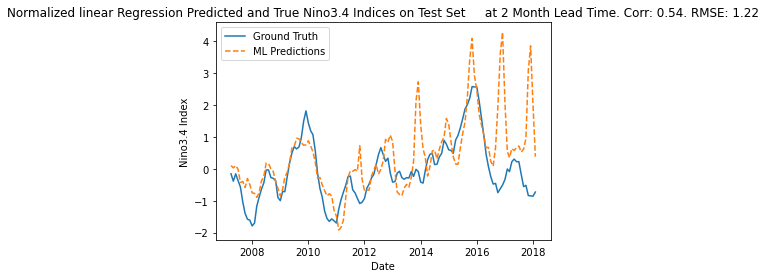

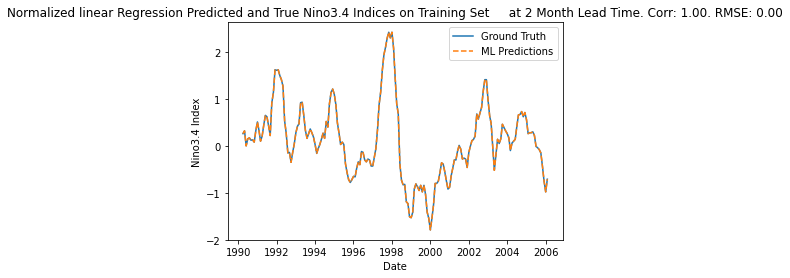

In [45]:
"""Plot the performance of Normalized linear regression at 1 month ahead lead time"""
#1 month Normalized linear regression (lr) model
train_start_date = '1990-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2 #change this and explore what happens!
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps)

scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
train_predictors = scaler.fit_transform(train_predictors)
test_predictors  = scaler.transform(test_predictors)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Normalized linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

sklearn_predictions = regr_1_month_lr.predict(train_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, train_predictands)
rmse = mean_squared_error(sklearn_predictions, train_predictands)
plot_nino_time_series(train_predictands, sklearn_predictions,
    'Normalized linear Regression Predicted and True Nino3.4 Indices on Training Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

### Ridge regression

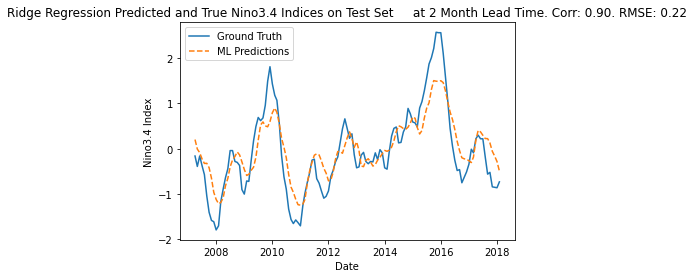

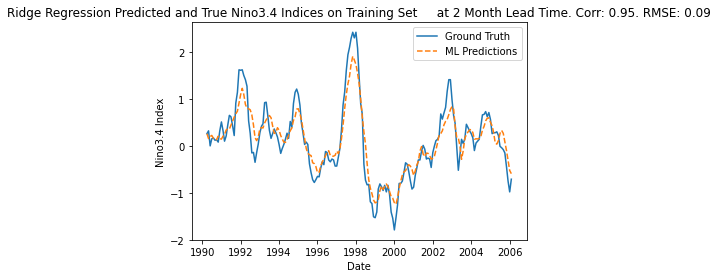

In [44]:
"""Plot the performance of Ridge regression at 1 month ahead lead time"""
#1 month Ridge regression (lr) model
train_start_date = '1990-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2 #change this and explore what happens!
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps)

#scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
#train_predictors = scaler.fit_transform(train_predictors)
#test_predictors  = scaler.transform(test_predictors)

regr_1_month_lr = sklearn.linear_model.Ridge(alpha=80000.0)
regr_1_month_lr.fit(train_predictors,train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Ridge Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))
sklearn_predictions = regr_1_month_lr.predict(train_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, train_predictands)
rmse = mean_squared_error(sklearn_predictions, train_predictands)
plot_nino_time_series(train_predictands, sklearn_predictions,
    'Ridge Regression Predicted and True Nino3.4 Indices on Training Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

### RandomForest

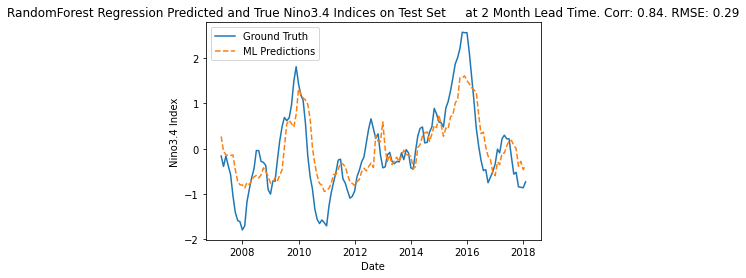

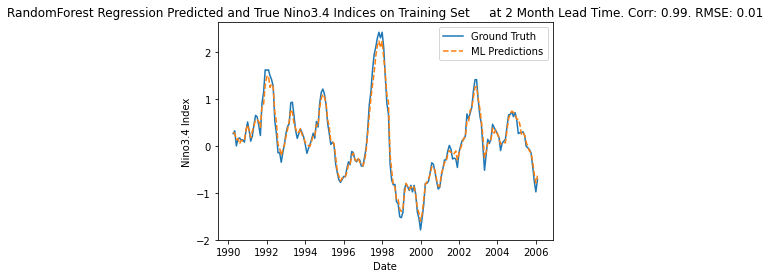

In [47]:
"""Plot the performance of RandomForest regression at 1 month ahead lead time"""
#1 month RandomForest regression (lr) model
train_start_date = '1990-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2 #change this and explore what happens!
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps)

scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
train_predictors = scaler.fit_transform(train_predictors)
test_predictors  = scaler.transform(test_predictors)

regr_1_month_lr = sklearn.ensemble.RandomForestRegressor(max_depth=30, n_estimators=50)
regr_1_month_lr.fit(train_predictors,train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
rmse = mean_squared_error(sklearn_predictions, test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'RandomForest Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))
sklearn_predictions = regr_1_month_lr.predict(train_predictors)
corr, _ = scipy.stats.pearsonr(sklearn_predictions, train_predictands)
rmse = mean_squared_error(sklearn_predictions, train_predictands)
plot_nino_time_series(train_predictands, sklearn_predictions,
    'RandomForest Regression Predicted and True Nino3.4 Indices on Training Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

## Excercise 3: What data sources improve the ML algorithm? What data sources do not imprve the ML algorithm?

Let's try training our ENSO forecasting model on old data (i.e. early 1900s) from the Cobe SST dataset.  There is significantly more uncertainty with this data than there is with newer data, since the advent of remote sensing and data sources has improved.

**GOAL OF THIS EXERCISE**: generate two plots: one showing the time series of predicted and true Niño3.4 indices with an ML model trained on 1900-1930 data.  The other should show the same (time series of prediced and true Niño3.4 indices with a model trained on 1975-2005 data.  (Both trained algorithms should be tested on data from 2007-2018.)

### Ridge

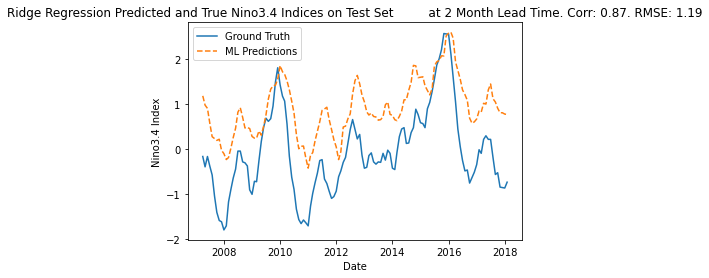

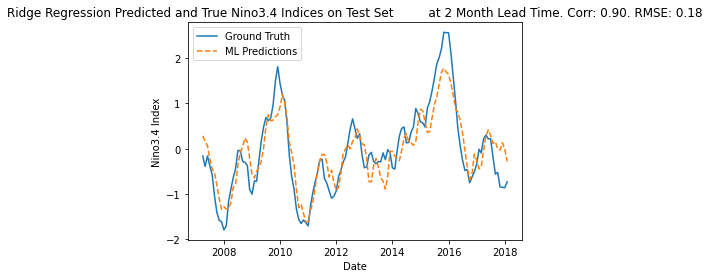

In [51]:
for train_start_date, train_end_date in [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]:
    #1 month linear regression (lr) model
    #train_start_date = '1990-01-01'
    #train_end_date = '2005-12-31'
    num_input_time_steps = 2
    lead_time = 2 #change this and explore what happens!
    train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                          train_end_date, lead_time, 'observations', 'flatten', 
                          num_input_time_steps=num_input_time_steps)
    test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                        '2017-12-31', lead_time, 'observations', 'flatten', 
                        num_input_time_steps=num_input_time_steps)

    scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
    train_predictors = scaler.fit_transform(train_predictors)
    test_predictors  = scaler.transform(test_predictors)

    regr_1_month_lr = sklearn.linear_model.Ridge(alpha=80000.0)
    regr_1_month_lr.fit(train_predictors,train_predictands)

    sklearn_predictions = regr_1_month_lr.predict(test_predictors)
    corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
    rmse = mean_squared_error(sklearn_predictions, test_predictands)
    plot_nino_time_series(test_predictands, sklearn_predictions,
        'Ridge Regression Predicted and True Nino3.4 Indices on Test Set \
        at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

    #sklearn_predictions = regr_1_month_lr.predict(train_predictors)
    #corr, _ = scipy.stats.pearsonr(sklearn_predictions, train_predictands)
    #rmse = mean_squared_error(sklearn_predictions, train_predictands)
    #plot_nino_time_series(train_predictands, sklearn_predictions,
    #    'Ridge Regression Predicted and True Nino3.4 Indices on Training Set \
    #    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

### RandomForest

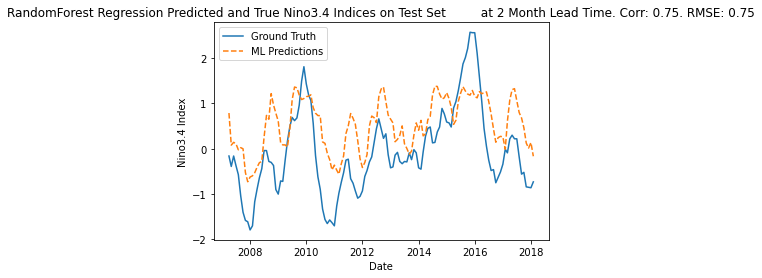

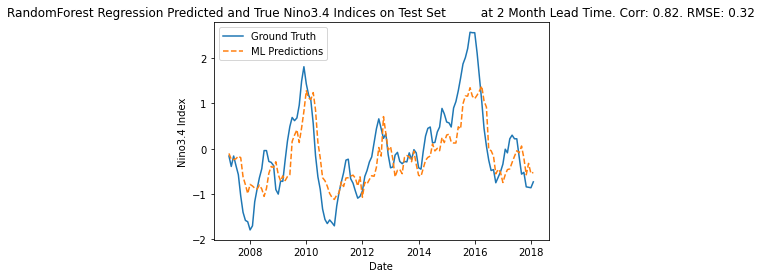

In [55]:
for train_start_date, train_end_date in [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]:
    #1 month linear regression (lr) model
    #train_start_date = '1990-01-01'
    #train_end_date = '2005-12-31'
    num_input_time_steps = 2
    lead_time = 2 #change this and explore what happens!
    train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                          train_end_date, lead_time, 'observations', 'flatten', 
                          num_input_time_steps=num_input_time_steps)
    test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                        '2017-12-31', lead_time, 'observations', 'flatten', 
                        num_input_time_steps=num_input_time_steps)

    scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
    train_predictors = scaler.fit_transform(train_predictors)
    test_predictors  = scaler.transform(test_predictors)

    regr_1_month_lr = sklearn.ensemble.RandomForestRegressor(max_depth=5, n_estimators=10)
    regr_1_month_lr.fit(train_predictors,train_predictands)

    sklearn_predictions = regr_1_month_lr.predict(test_predictors)
    corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
    rmse = mean_squared_error(sklearn_predictions, test_predictands)
    plot_nino_time_series(test_predictands, sklearn_predictions,
        'RandomForest Regression Predicted and True Nino3.4 Indices on Test Set \
        at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

    #sklearn_predictions = regr_1_month_lr.predict(train_predictors)
    #corr, _ = scipy.stats.pearsonr(sklearn_predictions, train_predictands)
    #rmse = mean_squared_error(sklearn_predictions, train_predictands)
    #plot_nino_time_series(train_predictands, sklearn_predictions,
    #    'Ridge Regression Predicted and True Nino3.4 Indices on Training Set \
    #    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

### Gradient Boosting Tree

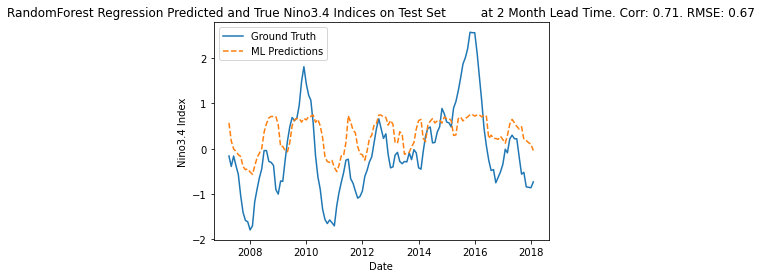

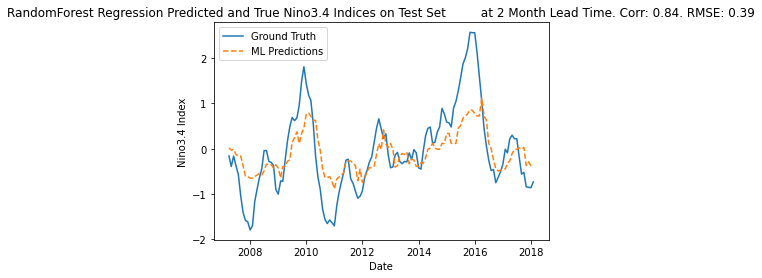

In [57]:
for train_start_date, train_end_date in [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]:
    #1 month linear regression (lr) model
    #train_start_date = '1990-01-01'
    #train_end_date = '2005-12-31'
    num_input_time_steps = 2
    lead_time = 2 #change this and explore what happens!
    train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                          train_end_date, lead_time, 'observations', 'flatten', 
                          num_input_time_steps=num_input_time_steps)
    test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                        '2017-12-31', lead_time, 'observations', 'flatten', 
                        num_input_time_steps=num_input_time_steps)

    scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
    train_predictors = scaler.fit_transform(train_predictors)
    test_predictors  = scaler.transform(test_predictors)

    regr_1_month_lr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=10)
    regr_1_month_lr.fit(train_predictors,train_predictands)

    sklearn_predictions = regr_1_month_lr.predict(test_predictors)
    corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
    rmse = mean_squared_error(sklearn_predictions, test_predictands)
    plot_nino_time_series(test_predictands, sklearn_predictions,
        'RandomForest Regression Predicted and True Nino3.4 Indices on Test Set \
        at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

    #sklearn_predictions = regr_1_month_lr.predict(train_predictors)
    #corr, _ = scipy.stats.pearsonr(sklearn_predictions, train_predictands)
    #rmse = mean_squared_error(sklearn_predictions, train_predictands)
    #plot_nino_time_series(train_predictands, sklearn_predictions,
    #    'Ridge Regression Predicted and True Nino3.4 Indices on Training Set \
    #    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

## Exercise 4: Data wrangling: Do machine learning algorithms perform better with a classification problem or regression problem?

Convert the problem from regression (predicting a continuous value) to classification (predicting a discrete value).  In this case, the continuous value is the exact value of the Niño3.4 index.  

Let's bin the Niño3.4 index to two values: 0 and 1.  Let's say negative values of the Niño3.4 index should be mapped to 0 and positive values of the index should be mapped to 1.

### Goal of the exercise:

Train a neural network and an sklearn logistic regression model to predict 0 or 1 corresponding to the mapping above!  Try changing the neural network's loss function from `nn.MSELoss` to `nn.BCEWithLogitsLoss`!

In [ ]:
#1.Adjust the train_network method so that the target is always 0 or 1. Maybe add an
# argument called "classification" that takes in a boolean value indicating
# whether or not to map the target to 0 or 1.
#2. Change the loss function of the neural network
#3. Run the train_network method to get the neural network predictions
#4. You will have to write your own code to calculate the accuracy of these predictions!

### Linear 

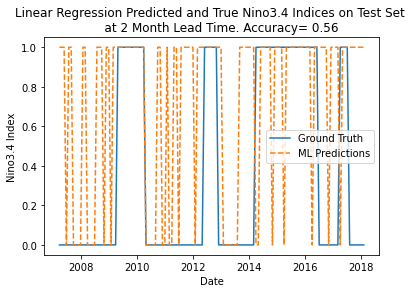

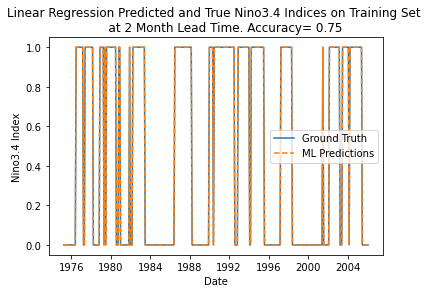

In [134]:
"""Plot the performance of Logistic regression at 1 month ahead lead time"""
#1 month Logistic regression (lr) model
train_start_date = '1975-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2 #change this and explore what happens!
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps)

train_predictands = train_predictands>0
test_predictands = test_predictands>0

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
#corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
#rmse = mean_squared_error(sklearn_predictions, test_predictands)
accu = np.sum((sklearn_predictions>0) == test_predictands)/len(test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions>0,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \n \
    at {} Month Lead Time. Accuracy= {:.2f}'.format(lead_time, accu))

sklearn_predictions = regr_1_month_lr.predict(train_predictors)
#corr, _ = scipy.stats.pearsonr(sklearn_predictions, train_predictands)
#rmse = mean_squared_error(sklearn_predictions, train_predictands)
accu = np.sum((sklearn_predictions>0) == train_predictands)/len(train_predictands)
plot_nino_time_series(train_predictands, sklearn_predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Training Set \n \
    at {} Month Lead Time. Accuracy= {:.2f}'.format(lead_time, accu))

### Logistic

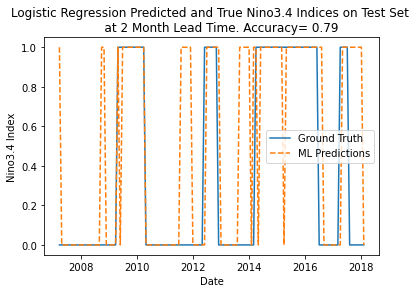

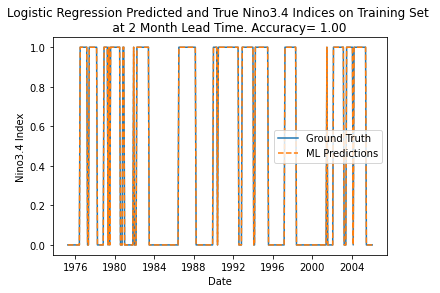

In [120]:
"""Plot the performance of Logistic regression at 1 month ahead lead time"""
#1 month Logistic regression (lr) model
train_start_date = '1975-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2 #change this and explore what happens!
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps)

train_predictands = train_predictands>0
test_predictands = test_predictands>0

regr_1_month_lr = sklearn.linear_model.LogisticRegression(max_iter=500)
regr_1_month_lr.fit(train_predictors,train_predictands)

sklearn_predictions = regr_1_month_lr.predict(test_predictors)
#corr, _ = scipy.stats.pearsonr(sklearn_predictions, test_predictands)
#rmse = mean_squared_error(sklearn_predictions, test_predictands)
accu = np.sum(sklearn_predictions == test_predictands)/len(test_predictands)
plot_nino_time_series(test_predictands, sklearn_predictions,
    'Logistic Regression Predicted and True Nino3.4 Indices on Test Set \n \
    at {} Month Lead Time. Accuracy= {:.2f}'.format(lead_time, accu))

sklearn_predictions = regr_1_month_lr.predict(train_predictors)
#corr, _ = scipy.stats.pearsonr(sklearn_predictions, train_predictands)
#rmse = mean_squared_error(sklearn_predictions, train_predictands)
accu = np.sum(sklearn_predictions == train_predictands)/len(train_predictands)
plot_nino_time_series(train_predictands, sklearn_predictions,
    'Logistic Regression Predicted and True Nino3.4 Indices on Training Set \n \
    at {} Month Lead Time. Accuracy= {:.2f}'.format(lead_time, accu))

### CNN

In [139]:
def train_network_binary(net, criterion, optimizer, trainloader, testloader, 
                         experiment_name, num_epochs=40):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network 
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.infty
  train_losses, test_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('test', testloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'test':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()

          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands.squeeze())

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()
          
          #Save the model weights that have the best performance!
        

          running_loss += loss.item()
      if running_loss < best_loss and mode == 'test':
          best_loss = running_loss
          torch.save(net, '{}.pt'.format(experiment_name))
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          test_losses.append(running_loss/len(data_loader))
    
  net = torch.load('{}.pt'.format(experiment_name))
  net.eval()
  net.to(device)
  
  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()
    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions>0, train_losses, test_losses


In [131]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#train_predictands=sklearn.preprocessing.binarize(np.array(train_predictands).reshape(-1,1), threshold=0, )
#test_predictands=sklearn.preprocessing.binarize(np.array(test_predictands).reshape(-1,1), threshold=0, )
train_predictands = (train_predictands>0)*1.0
test_predictands  = (test_predictands>0)*1.0

#Convert the numpy ararys into ENSODataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network_binary(net, nn.BCEWithLogitsLoss(), 
                  optimizer, trainloader, testloader, experiment_name)

train Set: Epoch 01. loss: 0.663694
test Set: Epoch 01. loss: 0.538180


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.474982
test Set: Epoch 02. loss: 0.389941
train Set: Epoch 03. loss: 0.328839
test Set: Epoch 03. loss: 0.350391
train Set: Epoch 04. loss: 0.253508
test Set: Epoch 04. loss: 0.394082
train Set: Epoch 05. loss: 0.209024
test Set: Epoch 05. loss: 0.498351
train Set: Epoch 06. loss: 0.189972
test Set: Epoch 06. loss: 0.521035
train Set: Epoch 07. loss: 0.191904
test Set: Epoch 07. loss: 0.374506
train Set: Epoch 08. loss: 0.214819
test Set: Epoch 08. loss: 0.357424
train Set: Epoch 09. loss: 0.180898
test Set: Epoch 09. loss: 0.412548
train Set: Epoch 10. loss: 0.182560
test Set: Epoch 10. loss: 0.397490
train Set: Epoch 11. loss: 0.189874
test Set: Epoch 11. loss: 0.444187
train Set: Epoch 12. loss: 0.163729
test Set: Epoch 12. loss: 0.417898
train Set: Epoch 13. loss: 0.186043
test Set: Epoch 13. loss: 0.403914
train Set: Epoch 14. loss: 0.144615
test Set: Epoch 14. loss: 0.455765
train Set: Epoch 15. loss: 0.141067
test Set: Epoch 15. loss: 0.498420
train 

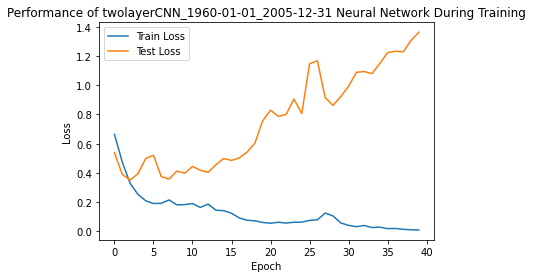

In [132]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

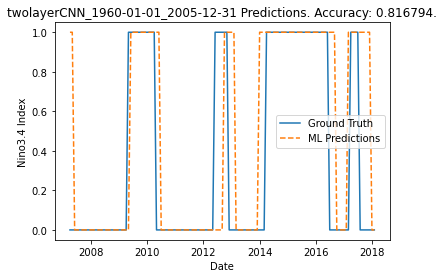

In [133]:
#corr, _ = pearsonr(test_predictands, predictions)
#rmse = mean_squared_error(test_predictands, predictions) ** 0.5
accu = np.sum(predictions == test_predictands)/len(test_predictands)
plot_nino_time_series(test_predictands, predictions, '{} Predictions. Accuracy: {:3f}.'.format(experiment_name,
                                                                      accu,))

# Wednesday

## Exercise 5: GCMS!

In the deep learning for ENSO forecasting papers, the key breakthrough that allowed for state-of-the-art performance is that the algorithms were trained on general circulation models (GCMs).  The availability of observed data is very limited.  With simulated data, neural networks are able to see more data and thus learn better.

## Goal for this exercise:

Train a neural network on data from GCMs.  The MPI GCM has data from the years 1850 to .  The CNRM GCM has data from the years .  Does more data help?  Does the increase in data make it possible to train on longer lead times?

In [147]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1860-01-01'
train_end_date = '2100-12-31'
num_input_time_steps = 2
lead_time = 2
climate_model = 'MPI'


train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, climate_model, 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the 
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_MPI_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                  optimizer, trainloader, testloader, experiment_name,
                  num_epochs=10)

/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning:

train Set: Epoch 01. loss: 0.386809
test Set: Epoch 01. loss: 0.307843
train Set: Epoch 02. loss: 0.094538
test Set: Epoch 02. loss: 0.256620
train Set: Epoch 03. loss: 0.061307
test Set: Epoch 03. loss: 0.246976
train Set: Epoch 04. loss: 0.049825
test Set: Epoch 04. loss: 0.239708
train Set: Epoch 05. loss: 0.039439
test Set: Epoch 05. loss: 0.239502
train Set: Epoch 06. loss: 0.033178
test Set: Epoch 06. loss: 0.236112
train Set: Epoch 07. loss: 0.029513
test Set: Epoch 07. loss: 0.238320
train Set: Epoch 08. loss: 0.026510
test Set: Epoch 08. loss: 0.241625
train Set: Epoch 09. loss: 0.028954
test Set: Epoch 09. loss: 0.256064
train Set: Epoch 10. loss: 0.047075
test Set: Epoch 10. loss: 0.260358


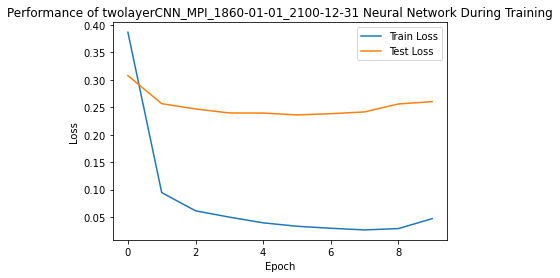

In [148]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

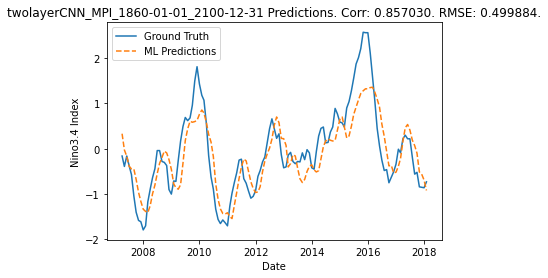

In [149]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(test_predictands, predictions, '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name,
                                                                      corr, rmse))

In [167]:
def test(leadtime=2, num_input=3, train_per=0.99):
    #Assemble numpy arrays corresponding to predictors and predictands
    train_start_date = '1860-01-01'
    train_end_date = '2100-12-31'
    num_input_time_steps = num_input
    lead_time = leadtime
    climate_model = 'MPI'


    train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                          train_end_date, lead_time, climate_model, 'spatial', num_input_time_steps=num_input_time_steps)
    test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                        '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

    train_predictors, _ , train_predictands, _ = train_test_split(train_predictors, train_predictands, train_size=p, random_state=0, )

    #Convert the numpy ararys into ENSODataset, which is a subset of the 
    #torch.utils.data.Dataset class.  This class is compatible with
    #the torch dataloader, which allows for data loading for a CNN
    train_dataset = ENSODataset(train_predictors, train_predictands)
    test_dataset = ENSODataset(test_predictors, test_predictands)

    #Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
    #the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
    trainloader = DataLoader(train_dataset, batch_size=10)
    testloader = DataLoader(test_dataset, batch_size=10)
    net = CNN(num_input_time_steps=num_input_time_steps)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    experiment_name = "twolayerCNN_MPI_{}_{}".format(train_start_date, train_end_date)
    predictions, train_losses, test_losses = train_network(net, nn.MSELoss(), 
                      optimizer, trainloader, testloader, experiment_name,
                      num_epochs=10)
    corr, _ = pearsonr(test_predictands, predictions)
    rmse = mean_squared_error(test_predictands, predictions) ** 0.5
    return corr, rmse

In [168]:
corr_per_collect = []
rmse_per_collect = []
for l in range(0,7,2):
    for p in np.arange(0.1,1,0.2):
        c, r = test(leadtime=l,train_per=p)
        corr_per_collect.append(c)
        rmse_per_collect.append(r)

/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.488475


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.529192
train Set: Epoch 02. loss: 0.140042
test Set: Epoch 02. loss: 0.278222
train Set: Epoch 03. loss: 0.067531
test Set: Epoch 03. loss: 0.245887
train Set: Epoch 04. loss: 0.036520
test Set: Epoch 04. loss: 0.245775
train Set: Epoch 05. loss: 0.080992
test Set: Epoch 05. loss: 0.308022
train Set: Epoch 06. loss: 0.065987
test Set: Epoch 06. loss: 0.235048
train Set: Epoch 07. loss: 0.040896
test Set: Epoch 07. loss: 0.224660
train Set: Epoch 08. loss: 0.046644
test Set: Epoch 08. loss: 0.246821
train Set: Epoch 09. loss: 0.079953
test Set: Epoch 09. loss: 0.283839
train Set: Epoch 10. loss: 0.031702
test Set: Epoch 10. loss: 0.227192


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.237981
test Set: Epoch 01. loss: 0.251040


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.057368
test Set: Epoch 02. loss: 0.197880
train Set: Epoch 03. loss: 0.051457
test Set: Epoch 03. loss: 0.193907
train Set: Epoch 04. loss: 0.047654
test Set: Epoch 04. loss: 0.158713
train Set: Epoch 05. loss: 0.025837
test Set: Epoch 05. loss: 0.152219
train Set: Epoch 06. loss: 0.020711
test Set: Epoch 06. loss: 0.167173
train Set: Epoch 07. loss: 0.019201
test Set: Epoch 07. loss: 0.150114
train Set: Epoch 08. loss: 0.013628
test Set: Epoch 08. loss: 0.132333
train Set: Epoch 09. loss: 0.008534
test Set: Epoch 09. loss: 0.125593
train Set: Epoch 10. loss: 0.005523
test Set: Epoch 10. loss: 0.126511


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.137718
test Set: Epoch 01. loss: 0.130268


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.031895
test Set: Epoch 02. loss: 0.116380
train Set: Epoch 03. loss: 0.031113
test Set: Epoch 03. loss: 0.128669
train Set: Epoch 04. loss: 0.020337
test Set: Epoch 04. loss: 0.112567
train Set: Epoch 05. loss: 0.015889
test Set: Epoch 05. loss: 0.105196
train Set: Epoch 06. loss: 0.018029
test Set: Epoch 06. loss: 0.107006
train Set: Epoch 07. loss: 0.017504
test Set: Epoch 07. loss: 0.103917
train Set: Epoch 08. loss: 0.009517
test Set: Epoch 08. loss: 0.099991
train Set: Epoch 09. loss: 0.010700
test Set: Epoch 09. loss: 0.101750
train Set: Epoch 10. loss: 0.022715
test Set: Epoch 10. loss: 0.111615


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.147352
test Set: Epoch 01. loss: 0.188532


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.024614
test Set: Epoch 02. loss: 0.163359
train Set: Epoch 03. loss: 0.014448
test Set: Epoch 03. loss: 0.141162
train Set: Epoch 04. loss: 0.016289
test Set: Epoch 04. loss: 0.125610
train Set: Epoch 05. loss: 0.014670
test Set: Epoch 05. loss: 0.117041
train Set: Epoch 06. loss: 0.008780
test Set: Epoch 06. loss: 0.110303
train Set: Epoch 07. loss: 0.007350
test Set: Epoch 07. loss: 0.109502
train Set: Epoch 08. loss: 0.007454
test Set: Epoch 08. loss: 0.109917
train Set: Epoch 09. loss: 0.009993
test Set: Epoch 09. loss: 0.115977
train Set: Epoch 10. loss: 0.010373
test Set: Epoch 10. loss: 0.100351


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning:

train Set: Epoch 01. loss: 0.128259
test Set: Epoch 01. loss: 0.142063
train Set: Epoch 02. loss: 0.015830
test Set: Epoch 02. loss: 0.129505
train Set: Epoch 03. loss: 0.010639
test Set: Epoch 03. loss: 0.135998
train Set: Epoch 04. loss: 0.008267
test Set: Epoch 04. loss: 0.129768
train Set: Epoch 05. loss: 0.010182
test Set: Epoch 05. loss: 0.121388
train Set: Epoch 06. loss: 0.007432
test Set: Epoch 06. loss: 0.117806
train Set: Epoch 07. loss: 0.005512
test Set: Epoch 07. loss: 0.116491
train Set: Epoch 08. loss: 0.005462
test Set: Epoch 08. loss: 0.107758
train Set: Epoch 09. loss: 0.007343
test Set: Epoch 09. loss: 0.113579
train Set: Epoch 10. loss: 0.008167
test Set: Epoch 10. loss: 0.110353


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.631780
test Set: Epoch 01. loss: 0.799019


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.361713
test Set: Epoch 02. loss: 0.485226
train Set: Epoch 03. loss: 0.149852
test Set: Epoch 03. loss: 0.374325
train Set: Epoch 04. loss: 0.079700
test Set: Epoch 04. loss: 0.333455
train Set: Epoch 05. loss: 0.047521
test Set: Epoch 05. loss: 0.304900
train Set: Epoch 06. loss: 0.039880
test Set: Epoch 06. loss: 0.306207
train Set: Epoch 07. loss: 0.078339
test Set: Epoch 07. loss: 0.349915
train Set: Epoch 08. loss: 0.170585
test Set: Epoch 08. loss: 0.386946
train Set: Epoch 09. loss: 0.056914
test Set: Epoch 09. loss: 0.322517
train Set: Epoch 10. loss: 0.032489
test Set: Epoch 10. loss: 0.304358


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.461145
test Set: Epoch 01. loss: 0.356957


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.136164
test Set: Epoch 02. loss: 0.232177
train Set: Epoch 03. loss: 0.062993
test Set: Epoch 03. loss: 0.220230
train Set: Epoch 04. loss: 0.037201
test Set: Epoch 04. loss: 0.236569
train Set: Epoch 05. loss: 0.026920
test Set: Epoch 05. loss: 0.230800
train Set: Epoch 06. loss: 0.037386
test Set: Epoch 06. loss: 0.198068
train Set: Epoch 07. loss: 0.067222
test Set: Epoch 07. loss: 0.208385
train Set: Epoch 08. loss: 0.044672
test Set: Epoch 08. loss: 0.204625
train Set: Epoch 09. loss: 0.034798
test Set: Epoch 09. loss: 0.200609
train Set: Epoch 10. loss: 0.020308
test Set: Epoch 10. loss: 0.208739


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.256855
test Set: Epoch 01. loss: 0.298397


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.074007
test Set: Epoch 02. loss: 0.283703
train Set: Epoch 03. loss: 0.044840
test Set: Epoch 03. loss: 0.266151
train Set: Epoch 04. loss: 0.030431
test Set: Epoch 04. loss: 0.260759
train Set: Epoch 05. loss: 0.026919
test Set: Epoch 05. loss: 0.276516
train Set: Epoch 06. loss: 0.030511
test Set: Epoch 06. loss: 0.270319
train Set: Epoch 07. loss: 0.022054
test Set: Epoch 07. loss: 0.255267
train Set: Epoch 08. loss: 0.019675
test Set: Epoch 08. loss: 0.244628
train Set: Epoch 09. loss: 0.023739
test Set: Epoch 09. loss: 0.247501
train Set: Epoch 10. loss: 0.020554
test Set: Epoch 10. loss: 0.277914


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.218744
test Set: Epoch 01. loss: 0.303591


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.060135
test Set: Epoch 02. loss: 0.281937
train Set: Epoch 03. loss: 0.037650
test Set: Epoch 03. loss: 0.266726
train Set: Epoch 04. loss: 0.024388
test Set: Epoch 04. loss: 0.259607
train Set: Epoch 05. loss: 0.017786
test Set: Epoch 05. loss: 0.260467
train Set: Epoch 06. loss: 0.013800
test Set: Epoch 06. loss: 0.263944
train Set: Epoch 07. loss: 0.015531
test Set: Epoch 07. loss: 0.265375
train Set: Epoch 08. loss: 0.025984
test Set: Epoch 08. loss: 0.214464
train Set: Epoch 09. loss: 0.023651
test Set: Epoch 09. loss: 0.211503
train Set: Epoch 10. loss: 0.019552
test Set: Epoch 10. loss: 0.227356


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning:

train Set: Epoch 01. loss: 0.191616
test Set: Epoch 01. loss: 0.280651
train Set: Epoch 02. loss: 0.048735
test Set: Epoch 02. loss: 0.278021
train Set: Epoch 03. loss: 0.032815
test Set: Epoch 03. loss: 0.255271
train Set: Epoch 04. loss: 0.027163
test Set: Epoch 04. loss: 0.239978
train Set: Epoch 05. loss: 0.024085
test Set: Epoch 05. loss: 0.238377
train Set: Epoch 06. loss: 0.021339
test Set: Epoch 06. loss: 0.231571
train Set: Epoch 07. loss: 0.018060
test Set: Epoch 07. loss: 0.230252
train Set: Epoch 08. loss: 0.021810
test Set: Epoch 08. loss: 0.242310
train Set: Epoch 09. loss: 0.020038
test Set: Epoch 09. loss: 0.252387
train Set: Epoch 10. loss: 0.011215
test Set: Epoch 10. loss: 0.255703


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.669570
test Set: Epoch 01. loss: 0.696134


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.354105
test Set: Epoch 02. loss: 0.562887
train Set: Epoch 03. loss: 0.176075
test Set: Epoch 03. loss: 0.520739
train Set: Epoch 04. loss: 0.103581
test Set: Epoch 04. loss: 0.495565
train Set: Epoch 05. loss: 0.090995
test Set: Epoch 05. loss: 0.493067
train Set: Epoch 06. loss: 0.185259
test Set: Epoch 06. loss: 0.560490
train Set: Epoch 07. loss: 0.082191
test Set: Epoch 07. loss: 0.497159
train Set: Epoch 08. loss: 0.035637
test Set: Epoch 08. loss: 0.521116
train Set: Epoch 09. loss: 0.022357
test Set: Epoch 09. loss: 0.508736
train Set: Epoch 10. loss: 0.008986
test Set: Epoch 10. loss: 0.497882


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.382534


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.636960
train Set: Epoch 02. loss: 0.210947
test Set: Epoch 02. loss: 0.692621
train Set: Epoch 03. loss: 0.144616
test Set: Epoch 03. loss: 0.704162
train Set: Epoch 04. loss: 0.141402
test Set: Epoch 04. loss: 0.634145
train Set: Epoch 05. loss: 0.156414
test Set: Epoch 05. loss: 0.573664
train Set: Epoch 06. loss: 0.129245
test Set: Epoch 06. loss: 0.540462
train Set: Epoch 07. loss: 0.100108
test Set: Epoch 07. loss: 0.537680
train Set: Epoch 08. loss: 0.069739
test Set: Epoch 08. loss: 0.535075
train Set: Epoch 09. loss: 0.056349
test Set: Epoch 09. loss: 0.550917
train Set: Epoch 10. loss: 0.049884
test Set: Epoch 10. loss: 0.565445


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.326234
test Set: Epoch 01. loss: 0.507260


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.135751
test Set: Epoch 02. loss: 0.508072
train Set: Epoch 03. loss: 0.090742
test Set: Epoch 03. loss: 0.502801
train Set: Epoch 04. loss: 0.069138
test Set: Epoch 04. loss: 0.483089
train Set: Epoch 05. loss: 0.071966
test Set: Epoch 05. loss: 0.481826
train Set: Epoch 06. loss: 0.056410
test Set: Epoch 06. loss: 0.478816
train Set: Epoch 07. loss: 0.046202
test Set: Epoch 07. loss: 0.492635
train Set: Epoch 08. loss: 0.035078
test Set: Epoch 08. loss: 0.485660
train Set: Epoch 09. loss: 0.030974
test Set: Epoch 09. loss: 0.482215
train Set: Epoch 10. loss: 0.026743
test Set: Epoch 10. loss: 0.483557


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.340637


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.555663
train Set: Epoch 02. loss: 0.133716
test Set: Epoch 02. loss: 0.515810
train Set: Epoch 03. loss: 0.089748
test Set: Epoch 03. loss: 0.530956
train Set: Epoch 04. loss: 0.063634
test Set: Epoch 04. loss: 0.534911
train Set: Epoch 05. loss: 0.049885
test Set: Epoch 05. loss: 0.515202
train Set: Epoch 06. loss: 0.060750
test Set: Epoch 06. loss: 0.506803
train Set: Epoch 07. loss: 0.046613
test Set: Epoch 07. loss: 0.512676
train Set: Epoch 08. loss: 0.030983
test Set: Epoch 08. loss: 0.501241
train Set: Epoch 09. loss: 0.023677
test Set: Epoch 09. loss: 0.490638
train Set: Epoch 10. loss: 0.022637
test Set: Epoch 10. loss: 0.503798


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning:

train Set: Epoch 01. loss: 0.272664
test Set: Epoch 01. loss: 0.501101
train Set: Epoch 02. loss: 0.125111
test Set: Epoch 02. loss: 0.535279
train Set: Epoch 03. loss: 0.093025
test Set: Epoch 03. loss: 0.521457
train Set: Epoch 04. loss: 0.065310
test Set: Epoch 04. loss: 0.523426
train Set: Epoch 05. loss: 0.046534
test Set: Epoch 05. loss: 0.536975
train Set: Epoch 06. loss: 0.037211
test Set: Epoch 06. loss: 0.525268
train Set: Epoch 07. loss: 0.039483
test Set: Epoch 07. loss: 0.447397
train Set: Epoch 08. loss: 0.045918
test Set: Epoch 08. loss: 0.427203
train Set: Epoch 09. loss: 0.035288
test Set: Epoch 09. loss: 0.446880
train Set: Epoch 10. loss: 0.025923
test Set: Epoch 10. loss: 0.445553


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.756681
test Set: Epoch 01. loss: 0.877953


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.580778
test Set: Epoch 02. loss: 0.766451
train Set: Epoch 03. loss: 0.408969
test Set: Epoch 03. loss: 0.750556
train Set: Epoch 04. loss: 0.294921
test Set: Epoch 04. loss: 0.712247
train Set: Epoch 05. loss: 0.257373
test Set: Epoch 05. loss: 0.688404
train Set: Epoch 06. loss: 0.232336
test Set: Epoch 06. loss: 0.674140
train Set: Epoch 07. loss: 0.142235
test Set: Epoch 07. loss: 0.687696
train Set: Epoch 08. loss: 0.070893
test Set: Epoch 08. loss: 0.676757
train Set: Epoch 09. loss: 0.052941
test Set: Epoch 09. loss: 0.675541
train Set: Epoch 10. loss: 0.040056
test Set: Epoch 10. loss: 0.676242


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.572069
test Set: Epoch 01. loss: 0.704641


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.284697
test Set: Epoch 02. loss: 0.658106
train Set: Epoch 03. loss: 0.157334
test Set: Epoch 03. loss: 0.676349
train Set: Epoch 04. loss: 0.105431
test Set: Epoch 04. loss: 0.683561
train Set: Epoch 05. loss: 0.112629
test Set: Epoch 05. loss: 0.578033
train Set: Epoch 06. loss: 0.139405
test Set: Epoch 06. loss: 0.633411
train Set: Epoch 07. loss: 0.059243
test Set: Epoch 07. loss: 0.642487
train Set: Epoch 08. loss: 0.031745
test Set: Epoch 08. loss: 0.632666
train Set: Epoch 09. loss: 0.021978
test Set: Epoch 09. loss: 0.612820
train Set: Epoch 10. loss: 0.019464
test Set: Epoch 10. loss: 0.587210


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.413087


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.871573
train Set: Epoch 02. loss: 0.208256
test Set: Epoch 02. loss: 0.898950
train Set: Epoch 03. loss: 0.133880
test Set: Epoch 03. loss: 0.884804
train Set: Epoch 04. loss: 0.088030
test Set: Epoch 04. loss: 0.827722
train Set: Epoch 05. loss: 0.056121
test Set: Epoch 05. loss: 0.768813
train Set: Epoch 06. loss: 0.049583
test Set: Epoch 06. loss: 0.695343
train Set: Epoch 07. loss: 0.090459
test Set: Epoch 07. loss: 0.763088
train Set: Epoch 08. loss: 0.066074
test Set: Epoch 08. loss: 0.729761
train Set: Epoch 09. loss: 0.059392
test Set: Epoch 09. loss: 0.764950
train Set: Epoch 10. loss: 0.044337
test Set: Epoch 10. loss: 0.771208


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.370003
test Set: Epoch 01. loss: 0.755690


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.182499
test Set: Epoch 02. loss: 0.741116
train Set: Epoch 03. loss: 0.116914
test Set: Epoch 03. loss: 0.688771
train Set: Epoch 04. loss: 0.077130
test Set: Epoch 04. loss: 0.649110
train Set: Epoch 05. loss: 0.062610
test Set: Epoch 05. loss: 0.643683
train Set: Epoch 06. loss: 0.066865
test Set: Epoch 06. loss: 0.674304
train Set: Epoch 07. loss: 0.045612
test Set: Epoch 07. loss: 0.672017
train Set: Epoch 08. loss: 0.033939
test Set: Epoch 08. loss: 0.688841
train Set: Epoch 09. loss: 0.027938
test Set: Epoch 09. loss: 0.679591
train Set: Epoch 10. loss: 0.019885
test Set: Epoch 10. loss: 0.672389


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning:

train Set: Epoch 01. loss: 0.361827
test Set: Epoch 01. loss: 0.772074
train Set: Epoch 02. loss: 0.165571
test Set: Epoch 02. loss: 0.767863
train Set: Epoch 03. loss: 0.091725
test Set: Epoch 03. loss: 0.821152
train Set: Epoch 04. loss: 0.051214
test Set: Epoch 04. loss: 0.731155
train Set: Epoch 05. loss: 0.042073
test Set: Epoch 05. loss: 0.728500
train Set: Epoch 06. loss: 0.035856
test Set: Epoch 06. loss: 0.686544
train Set: Epoch 07. loss: 0.051657
test Set: Epoch 07. loss: 0.722113
train Set: Epoch 08. loss: 0.028360
test Set: Epoch 08. loss: 0.766496
train Set: Epoch 09. loss: 0.017216
test Set: Epoch 09. loss: 0.753410
train Set: Epoch 10. loss: 0.019354
test Set: Epoch 10. loss: 0.722686


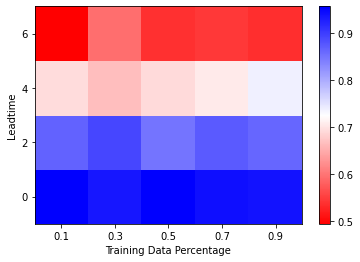

In [176]:
plt.pcolormesh(np.array(corr_per_collect).reshape(4,5),cmap='bwr_r')
plt.yticks(np.arange(4)+0.5, range(0,7,2))
plt.xticks(np.arange(5)+0.5, np.arange(1,10,2)/10)
plt.ylabel('Leadtime')
plt.xlabel('Training Data Percentage')
plt.colorbar()

## Exercise 6: Data Wrangling.  Should the predictors be the entire globe? Or just a specific region?

The Ham et. al. paper only uses Pacific temperatures to forecast the Niño3.4 index.  However, the Mahesh et. al. paper uses the entire globe.

Hypothesize which method you think might be better!  What assumptions does your hypothesis rely on?  Recall the bias-variance tradeoff that we discussed in the previous notebook!


*   Let's assume there is NO useful information for forecasting ENSO outside of the Pacific.  In other words, the rest of the world has no predictive power.  Would it make sense to use the entire globe as a predictor?  Discuss in the context of the bias-variance tradeoff.

The reality is probably mixed: the rest of the globe has some predictive power, but it also has noise!  Therefore, it's a tradeoff, because noisy inputs hurt model performance, but predictive inputs help performance!

#### GOAL OF THIS EXERCISE

Check out slicing xarray datasets by latitude and longitude at this [link](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html).

Fill in the code in the `assemble_predictors_predictands` method for the slicing!

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


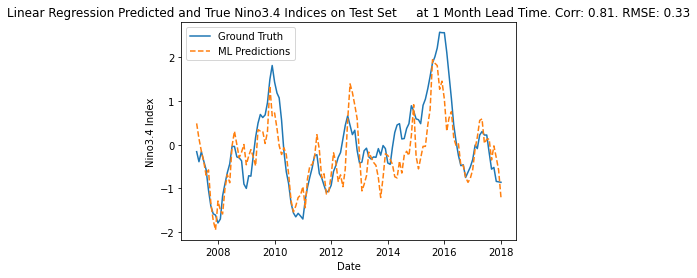

In [25]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 3
lead_time = 1
#Extract the following slice of latitude
lat_slice = slice(10, -10)
#Extract the following slice of longitude
lon_slice = slice(360-170,360-120)
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                      lon_slice=lon_slice)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                    lon_slice=lon_slice)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(predictions, test_predictands)
rmse = mean_squared_error(predictions, test_predictands)
plot_nino_time_series(test_predictands, predictions,
    'Linear Regression Predicted and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

In [26]:
print("R2 score:", sklearn.metrics.r2_score(test_predictands, predictions))

R2 score: 0.6253259748218604


Now, let's do a sanity check.  Let's change `lat_slice` and `lon_slice` to random regions, where it is unlikely there is any ENSO signal.  Let's observe the performance of the model!

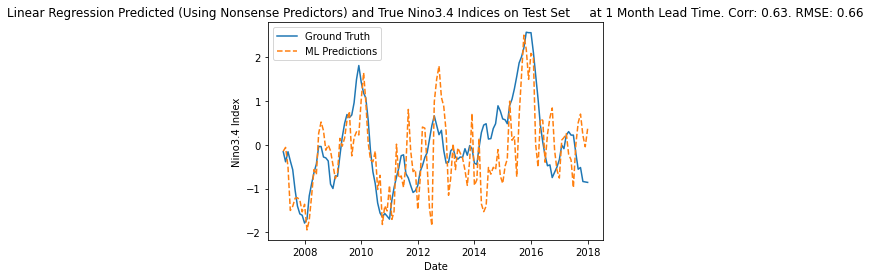

In [173]:
#Aassemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 3
lead_time = 1
#Extract the following slice of latitude
lat_slice = slice(40, -50)
#Extract the following slice of longitude
lon_slice = slice(0,100)
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                      lon_slice=lon_slice)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                    lon_slice=lon_slice)

regr_1_month_lr = sklearn.linear_model.LinearRegression()
regr_1_month_lr.fit(train_predictors,train_predictands)

predictions = regr_1_month_lr.predict(test_predictors)
corr, _ = scipy.stats.pearsonr(predictions, test_predictands)
rmse = mean_squared_error(predictions, test_predictands)
plot_nino_time_series(test_predictands, predictions,
    'Linear Regression Predicted (Using Nonsense Predictors) and True Nino3.4 Indices on Test Set \
    at {} Month Lead Time. Corr: {:.2f}. RMSE: {:.2f}'.format(lead_time, corr, rmse))

# Thursday

# Excercise 7: Time Series of Gridded Monthly Temperature.  

Our inputs have so far have had 3 input months as each predictor, that is, `num_input_time_steps=3`.  Let's try changing this value and see how it affects the performance of our model!

**GOAL OF THIS EXERCISE:** Make a 2D matrix.  One axis denotes different values of `num_input_time_steps` . The other axis denotes different lead_times.  Plot the resulting matrix!

In [ ]:
for num_input_time_steps in range(1,7):
  for lead_time in range(1,5):
    experiment_name = "twolayerCNN_lead-{}_input-{}".format(num_input_time_steps, 
                                                            lead_time)
    """YOUR CODE HERE"""
    #Train and evaluate an ML algorithm of your choice on different
    #combinations of lead_time and num_input_time_steps.
    #Use plt.matshow to plot your results!

In [152]:
corr_collect = []
rmse_collect = []
for l in range(0,11,2):
    for n in range(1,10,2):
        c, r = test(l,n)
        corr_collect.append(c)
        rmse_collect.append(r)

/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.257593
test Set: Epoch 01. loss: 0.247291


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.067736
test Set: Epoch 02. loss: 0.178621
train Set: Epoch 03. loss: 0.047832
test Set: Epoch 03. loss: 0.159581
train Set: Epoch 04. loss: 0.036507
test Set: Epoch 04. loss: 0.139443
train Set: Epoch 05. loss: 0.035661
test Set: Epoch 05. loss: 0.130036
train Set: Epoch 06. loss: 0.053713
test Set: Epoch 06. loss: 0.157512
train Set: Epoch 07. loss: 0.036232
test Set: Epoch 07. loss: 0.130023
train Set: Epoch 08. loss: 0.033725
test Set: Epoch 08. loss: 0.128735
train Set: Epoch 09. loss: 0.049778
test Set: Epoch 09. loss: 0.127804
train Set: Epoch 10. loss: 0.039721
test Set: Epoch 10. loss: 0.127927


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.253662
test Set: Epoch 01. loss: 0.231465


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.061525
test Set: Epoch 02. loss: 0.176359
train Set: Epoch 03. loss: 0.030717
test Set: Epoch 03. loss: 0.146279
train Set: Epoch 04. loss: 0.029086
test Set: Epoch 04. loss: 0.148579
train Set: Epoch 05. loss: 0.026059
test Set: Epoch 05. loss: 0.122241
train Set: Epoch 06. loss: 0.021008
test Set: Epoch 06. loss: 0.117815
train Set: Epoch 07. loss: 0.015117
test Set: Epoch 07. loss: 0.126977
train Set: Epoch 08. loss: 0.015394
test Set: Epoch 08. loss: 0.130341
train Set: Epoch 09. loss: 0.030224
test Set: Epoch 09. loss: 0.136827
train Set: Epoch 10. loss: 0.030509
test Set: Epoch 10. loss: 0.121207


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.340648


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.331662
train Set: Epoch 02. loss: 0.091870
test Set: Epoch 02. loss: 0.236543
train Set: Epoch 03. loss: 0.046336
test Set: Epoch 03. loss: 0.221358
train Set: Epoch 04. loss: 0.033496
test Set: Epoch 04. loss: 0.192711
train Set: Epoch 05. loss: 0.030893
test Set: Epoch 05. loss: 0.169896
train Set: Epoch 06. loss: 0.041486
test Set: Epoch 06. loss: 0.162381
train Set: Epoch 07. loss: 0.047558
test Set: Epoch 07. loss: 0.164722
train Set: Epoch 08. loss: 0.034622
test Set: Epoch 08. loss: 0.163946
train Set: Epoch 09. loss: 0.021014
test Set: Epoch 09. loss: 0.147537
train Set: Epoch 10. loss: 0.011095
test Set: Epoch 10. loss: 0.141226


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.282226


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.284822
train Set: Epoch 02. loss: 0.067530
test Set: Epoch 02. loss: 0.276907
train Set: Epoch 03. loss: 0.046091
test Set: Epoch 03. loss: 0.170500
train Set: Epoch 04. loss: 0.032468
test Set: Epoch 04. loss: 0.163577
train Set: Epoch 05. loss: 0.030706
test Set: Epoch 05. loss: 0.160679
train Set: Epoch 06. loss: 0.038557
test Set: Epoch 06. loss: 0.135560
train Set: Epoch 07. loss: 0.035573
test Set: Epoch 07. loss: 0.135721
train Set: Epoch 08. loss: 0.028090
test Set: Epoch 08. loss: 0.103267
train Set: Epoch 09. loss: 0.016458
test Set: Epoch 09. loss: 0.101525
train Set: Epoch 10. loss: 0.007954
test Set: Epoch 10. loss: 0.099476


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.351742


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.323388
train Set: Epoch 02. loss: 0.091990
test Set: Epoch 02. loss: 0.240905
train Set: Epoch 03. loss: 0.049378
test Set: Epoch 03. loss: 0.254614
train Set: Epoch 04. loss: 0.045650
test Set: Epoch 04. loss: 0.246841
train Set: Epoch 05. loss: 0.050284
test Set: Epoch 05. loss: 0.263542
train Set: Epoch 06. loss: 0.055809
test Set: Epoch 06. loss: 0.224248
train Set: Epoch 07. loss: 0.055290
test Set: Epoch 07. loss: 0.183814
train Set: Epoch 08. loss: 0.033076
test Set: Epoch 08. loss: 0.164751
train Set: Epoch 09. loss: 0.016574
test Set: Epoch 09. loss: 0.148826
train Set: Epoch 10. loss: 0.010361
test Set: Epoch 10. loss: 0.144444


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.381812
test Set: Epoch 01. loss: 0.342899


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.124848
test Set: Epoch 02. loss: 0.308723
train Set: Epoch 03. loss: 0.085992
test Set: Epoch 03. loss: 0.298572
train Set: Epoch 04. loss: 0.065358
test Set: Epoch 04. loss: 0.285332
train Set: Epoch 05. loss: 0.052073
test Set: Epoch 05. loss: 0.268277
train Set: Epoch 06. loss: 0.044871
test Set: Epoch 06. loss: 0.260132
train Set: Epoch 07. loss: 0.042505
test Set: Epoch 07. loss: 0.263880
train Set: Epoch 08. loss: 0.042907
test Set: Epoch 08. loss: 0.248813
train Set: Epoch 09. loss: 0.038520
test Set: Epoch 09. loss: 0.211259
train Set: Epoch 10. loss: 0.034696
test Set: Epoch 10. loss: 0.199469


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.409400
test Set: Epoch 01. loss: 0.329733


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.133097
test Set: Epoch 02. loss: 0.254073
train Set: Epoch 03. loss: 0.076198
test Set: Epoch 03. loss: 0.239068
train Set: Epoch 04. loss: 0.054519
test Set: Epoch 04. loss: 0.232902
train Set: Epoch 05. loss: 0.042156
test Set: Epoch 05. loss: 0.227744
train Set: Epoch 06. loss: 0.033575
test Set: Epoch 06. loss: 0.222884
train Set: Epoch 07. loss: 0.028217
test Set: Epoch 07. loss: 0.225724
train Set: Epoch 08. loss: 0.025420
test Set: Epoch 08. loss: 0.242660
train Set: Epoch 09. loss: 0.027287
test Set: Epoch 09. loss: 0.293521
train Set: Epoch 10. loss: 0.034377
test Set: Epoch 10. loss: 0.280516


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.319747


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.299710
train Set: Epoch 02. loss: 0.095009
test Set: Epoch 02. loss: 0.263891
train Set: Epoch 03. loss: 0.070282
test Set: Epoch 03. loss: 0.251833
train Set: Epoch 04. loss: 0.052390
test Set: Epoch 04. loss: 0.238271
train Set: Epoch 05. loss: 0.040148
test Set: Epoch 05. loss: 0.230069
train Set: Epoch 06. loss: 0.034842
test Set: Epoch 06. loss: 0.234421
train Set: Epoch 07. loss: 0.038953
test Set: Epoch 07. loss: 0.305876
train Set: Epoch 08. loss: 0.034398
test Set: Epoch 08. loss: 0.315087
train Set: Epoch 09. loss: 0.039602
test Set: Epoch 09. loss: 0.363746
train Set: Epoch 10. loss: 0.060824
test Set: Epoch 10. loss: 0.290463


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.406760


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.337405
train Set: Epoch 02. loss: 0.109710
test Set: Epoch 02. loss: 0.293867
train Set: Epoch 03. loss: 0.065224
test Set: Epoch 03. loss: 0.269680
train Set: Epoch 04. loss: 0.046023
test Set: Epoch 04. loss: 0.270038
train Set: Epoch 05. loss: 0.037974
test Set: Epoch 05. loss: 0.277629
train Set: Epoch 06. loss: 0.038853
test Set: Epoch 06. loss: 0.349309
train Set: Epoch 07. loss: 0.058799
test Set: Epoch 07. loss: 0.351640
train Set: Epoch 08. loss: 0.076093
test Set: Epoch 08. loss: 0.304734
train Set: Epoch 09. loss: 0.074856
test Set: Epoch 09. loss: 0.295276
train Set: Epoch 10. loss: 0.044551
test Set: Epoch 10. loss: 0.268076


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.427751


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.367100
train Set: Epoch 02. loss: 0.115858
test Set: Epoch 02. loss: 0.311216
train Set: Epoch 03. loss: 0.076664
test Set: Epoch 03. loss: 0.289219
train Set: Epoch 04. loss: 0.054551
test Set: Epoch 04. loss: 0.278306
train Set: Epoch 05. loss: 0.041521
test Set: Epoch 05. loss: 0.272410
train Set: Epoch 06. loss: 0.033069
test Set: Epoch 06. loss: 0.274104
train Set: Epoch 07. loss: 0.033204
test Set: Epoch 07. loss: 0.289845
train Set: Epoch 08. loss: 0.057397
test Set: Epoch 08. loss: 0.327380
train Set: Epoch 09. loss: 0.069402
test Set: Epoch 09. loss: 0.302007
train Set: Epoch 10. loss: 0.055499
test Set: Epoch 10. loss: 0.295534


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.349448
test Set: Epoch 01. loss: 0.380493


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.174533
test Set: Epoch 02. loss: 0.392017
train Set: Epoch 03. loss: 0.129209
test Set: Epoch 03. loss: 0.394064
train Set: Epoch 04. loss: 0.102995
test Set: Epoch 04. loss: 0.387856
train Set: Epoch 05. loss: 0.084603
test Set: Epoch 05. loss: 0.409677
train Set: Epoch 06. loss: 0.071851
test Set: Epoch 06. loss: 0.471353
train Set: Epoch 07. loss: 0.072018
test Set: Epoch 07. loss: 0.573105
train Set: Epoch 08. loss: 0.080956
test Set: Epoch 08. loss: 0.537333
train Set: Epoch 09. loss: 0.094399
test Set: Epoch 09. loss: 0.493364
train Set: Epoch 10. loss: 0.091283
test Set: Epoch 10. loss: 0.441545


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.450728


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.570840
train Set: Epoch 02. loss: 0.177407
test Set: Epoch 02. loss: 0.495167
train Set: Epoch 03. loss: 0.123469
test Set: Epoch 03. loss: 0.476945
train Set: Epoch 04. loss: 0.096288
test Set: Epoch 04. loss: 0.477454
train Set: Epoch 05. loss: 0.079478
test Set: Epoch 05. loss: 0.501881
train Set: Epoch 06. loss: 0.074719
test Set: Epoch 06. loss: 0.579361
train Set: Epoch 07. loss: 0.093175
test Set: Epoch 07. loss: 0.554774
train Set: Epoch 08. loss: 0.101002
test Set: Epoch 08. loss: 0.572562
train Set: Epoch 09. loss: 0.106837
test Set: Epoch 09. loss: 0.551996
train Set: Epoch 10. loss: 0.094582
test Set: Epoch 10. loss: 0.527882


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.487804


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.540491
train Set: Epoch 02. loss: 0.213355
test Set: Epoch 02. loss: 0.505449
train Set: Epoch 03. loss: 0.152287
test Set: Epoch 03. loss: 0.475774
train Set: Epoch 04. loss: 0.126748
test Set: Epoch 04. loss: 0.499205
train Set: Epoch 05. loss: 0.114271
test Set: Epoch 05. loss: 0.531128
train Set: Epoch 06. loss: 0.116004
test Set: Epoch 06. loss: 0.516208
train Set: Epoch 07. loss: 0.110601
test Set: Epoch 07. loss: 0.476054
train Set: Epoch 08. loss: 0.098289
test Set: Epoch 08. loss: 0.471924
train Set: Epoch 09. loss: 0.074553
test Set: Epoch 09. loss: 0.476975
train Set: Epoch 10. loss: 0.056667
test Set: Epoch 10. loss: 0.486318


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.456615


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.527505
train Set: Epoch 02. loss: 0.185352
test Set: Epoch 02. loss: 0.540254
train Set: Epoch 03. loss: 0.130101
test Set: Epoch 03. loss: 0.551418
train Set: Epoch 04. loss: 0.098542
test Set: Epoch 04. loss: 0.586673
train Set: Epoch 05. loss: 0.077509
test Set: Epoch 05. loss: 0.659590
train Set: Epoch 06. loss: 0.067135
test Set: Epoch 06. loss: 0.792157
train Set: Epoch 07. loss: 0.089218
test Set: Epoch 07. loss: 0.683361
train Set: Epoch 08. loss: 0.115331
test Set: Epoch 08. loss: 0.542378
train Set: Epoch 09. loss: 0.087737
test Set: Epoch 09. loss: 0.532490
train Set: Epoch 10. loss: 0.060178
test Set: Epoch 10. loss: 0.525812


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.462830


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.532986
train Set: Epoch 02. loss: 0.213715
test Set: Epoch 02. loss: 0.474778
train Set: Epoch 03. loss: 0.154384
test Set: Epoch 03. loss: 0.494161
train Set: Epoch 04. loss: 0.116288
test Set: Epoch 04. loss: 0.500530
train Set: Epoch 05. loss: 0.096432
test Set: Epoch 05. loss: 0.497579
train Set: Epoch 06. loss: 0.096999
test Set: Epoch 06. loss: 0.499701
train Set: Epoch 07. loss: 0.101797
test Set: Epoch 07. loss: 0.503629
train Set: Epoch 08. loss: 0.091724
test Set: Epoch 08. loss: 0.524883
train Set: Epoch 09. loss: 0.068132
test Set: Epoch 09. loss: 0.511566
train Set: Epoch 10. loss: 0.053948
test Set: Epoch 10. loss: 0.504336


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.534379
test Set: Epoch 01. loss: 0.612284


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.325746
test Set: Epoch 02. loss: 0.567419
train Set: Epoch 03. loss: 0.253832
test Set: Epoch 03. loss: 0.574862
train Set: Epoch 04. loss: 0.207769
test Set: Epoch 04. loss: 0.603920
train Set: Epoch 05. loss: 0.174260
test Set: Epoch 05. loss: 0.639325
train Set: Epoch 06. loss: 0.145332
test Set: Epoch 06. loss: 0.674964
train Set: Epoch 07. loss: 0.122541
test Set: Epoch 07. loss: 0.715936
train Set: Epoch 08. loss: 0.103386
test Set: Epoch 08. loss: 0.750910
train Set: Epoch 09. loss: 0.093126
test Set: Epoch 09. loss: 0.759627
train Set: Epoch 10. loss: 0.095252
test Set: Epoch 10. loss: 0.735228


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.515000
test Set: Epoch 01. loss: 0.758312


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.291502
test Set: Epoch 02. loss: 0.773016
train Set: Epoch 03. loss: 0.223472
test Set: Epoch 03. loss: 0.821776
train Set: Epoch 04. loss: 0.172991
test Set: Epoch 04. loss: 0.872027
train Set: Epoch 05. loss: 0.134201
test Set: Epoch 05. loss: 0.906612
train Set: Epoch 06. loss: 0.102805
test Set: Epoch 06. loss: 0.955088
train Set: Epoch 07. loss: 0.089456
test Set: Epoch 07. loss: 0.850704
train Set: Epoch 08. loss: 0.097852
test Set: Epoch 08. loss: 0.779135
train Set: Epoch 09. loss: 0.100851
test Set: Epoch 09. loss: 0.773976
train Set: Epoch 10. loss: 0.097832
test Set: Epoch 10. loss: 0.852353


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.574555


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.695990
train Set: Epoch 02. loss: 0.344958
test Set: Epoch 02. loss: 0.698265
train Set: Epoch 03. loss: 0.270165
test Set: Epoch 03. loss: 0.758706
train Set: Epoch 04. loss: 0.214888
test Set: Epoch 04. loss: 0.782979
train Set: Epoch 05. loss: 0.169985
test Set: Epoch 05. loss: 0.848851
train Set: Epoch 06. loss: 0.138278
test Set: Epoch 06. loss: 0.859051
train Set: Epoch 07. loss: 0.116889
test Set: Epoch 07. loss: 0.861734
train Set: Epoch 08. loss: 0.101122
test Set: Epoch 08. loss: 0.888932
train Set: Epoch 09. loss: 0.089196
test Set: Epoch 09. loss: 0.907494
train Set: Epoch 10. loss: 0.078347
test Set: Epoch 10. loss: 0.887471


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.645806


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.759443
train Set: Epoch 02. loss: 0.368766
test Set: Epoch 02. loss: 0.677371
train Set: Epoch 03. loss: 0.254185
test Set: Epoch 03. loss: 0.673950
train Set: Epoch 04. loss: 0.204158
test Set: Epoch 04. loss: 0.690613
train Set: Epoch 05. loss: 0.159485
test Set: Epoch 05. loss: 0.724557
train Set: Epoch 06. loss: 0.125425
test Set: Epoch 06. loss: 0.727779
train Set: Epoch 07. loss: 0.100378
test Set: Epoch 07. loss: 0.720114
train Set: Epoch 08. loss: 0.088013
test Set: Epoch 08. loss: 0.717105
train Set: Epoch 09. loss: 0.098727
test Set: Epoch 09. loss: 0.687042
train Set: Epoch 10. loss: 0.119315
test Set: Epoch 10. loss: 0.730312


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.624281


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.748121
train Set: Epoch 02. loss: 0.369004
test Set: Epoch 02. loss: 0.720549
train Set: Epoch 03. loss: 0.251592
test Set: Epoch 03. loss: 0.738989
train Set: Epoch 04. loss: 0.199287
test Set: Epoch 04. loss: 0.749542
train Set: Epoch 05. loss: 0.166673
test Set: Epoch 05. loss: 0.736260
train Set: Epoch 06. loss: 0.133219
test Set: Epoch 06. loss: 0.736746
train Set: Epoch 07. loss: 0.107517
test Set: Epoch 07. loss: 0.733756
train Set: Epoch 08. loss: 0.103360
test Set: Epoch 08. loss: 0.684021
train Set: Epoch 09. loss: 0.111510
test Set: Epoch 09. loss: 0.680559
train Set: Epoch 10. loss: 0.088427
test Set: Epoch 10. loss: 0.679321


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.580666
test Set: Epoch 01. loss: 0.780242


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.409354
test Set: Epoch 02. loss: 0.830673
train Set: Epoch 03. loss: 0.332527
test Set: Epoch 03. loss: 0.905463
train Set: Epoch 04. loss: 0.283415
test Set: Epoch 04. loss: 0.952233
train Set: Epoch 05. loss: 0.239143
test Set: Epoch 05. loss: 1.020031
train Set: Epoch 06. loss: 0.202065
test Set: Epoch 06. loss: 1.076149
train Set: Epoch 07. loss: 0.168962
test Set: Epoch 07. loss: 1.132984
train Set: Epoch 08. loss: 0.138786
test Set: Epoch 08. loss: 1.181654
train Set: Epoch 09. loss: 0.113026
test Set: Epoch 09. loss: 1.270678
train Set: Epoch 10. loss: 0.098262
test Set: Epoch 10. loss: 1.369522


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.602621
test Set: Epoch 01. loss: 0.812344


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.405365
test Set: Epoch 02. loss: 0.848646
train Set: Epoch 03. loss: 0.321268
test Set: Epoch 03. loss: 0.911945
train Set: Epoch 04. loss: 0.265066
test Set: Epoch 04. loss: 0.959752
train Set: Epoch 05. loss: 0.219296
test Set: Epoch 05. loss: 1.069039
train Set: Epoch 06. loss: 0.169861
test Set: Epoch 06. loss: 1.141447
train Set: Epoch 07. loss: 0.126914
test Set: Epoch 07. loss: 1.190877
train Set: Epoch 08. loss: 0.095615
test Set: Epoch 08. loss: 1.224697
train Set: Epoch 09. loss: 0.079754
test Set: Epoch 09. loss: 1.217934
train Set: Epoch 10. loss: 0.088553
test Set: Epoch 10. loss: 1.128357


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.633715


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.765359
train Set: Epoch 02. loss: 0.425736
test Set: Epoch 02. loss: 0.769805
train Set: Epoch 03. loss: 0.317734
test Set: Epoch 03. loss: 0.826748
train Set: Epoch 04. loss: 0.252741
test Set: Epoch 04. loss: 0.877000
train Set: Epoch 05. loss: 0.195740
test Set: Epoch 05. loss: 0.921192
train Set: Epoch 06. loss: 0.141737
test Set: Epoch 06. loss: 0.931766
train Set: Epoch 07. loss: 0.102940
test Set: Epoch 07. loss: 0.942432
train Set: Epoch 08. loss: 0.101661
test Set: Epoch 08. loss: 1.006363
train Set: Epoch 09. loss: 0.152561
test Set: Epoch 09. loss: 0.843238
train Set: Epoch 10. loss: 0.136438
test Set: Epoch 10. loss: 0.795182


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.588989


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.786732
train Set: Epoch 02. loss: 0.384932
test Set: Epoch 02. loss: 0.909215
train Set: Epoch 03. loss: 0.299176
test Set: Epoch 03. loss: 1.022661
train Set: Epoch 04. loss: 0.223963
test Set: Epoch 04. loss: 1.146454
train Set: Epoch 05. loss: 0.170439
test Set: Epoch 05. loss: 1.238149
train Set: Epoch 06. loss: 0.123950
test Set: Epoch 06. loss: 1.166090
train Set: Epoch 07. loss: 0.123577
test Set: Epoch 07. loss: 1.004151
train Set: Epoch 08. loss: 0.146554
test Set: Epoch 08. loss: 0.984940
train Set: Epoch 09. loss: 0.120820
test Set: Epoch 09. loss: 1.029513
train Set: Epoch 10. loss: 0.092577
test Set: Epoch 10. loss: 0.983371


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.655772


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.768478
train Set: Epoch 02. loss: 0.502757
test Set: Epoch 02. loss: 0.845192
train Set: Epoch 03. loss: 0.341027
test Set: Epoch 03. loss: 0.947643
train Set: Epoch 04. loss: 0.248533
test Set: Epoch 04. loss: 0.993440
train Set: Epoch 05. loss: 0.192613
test Set: Epoch 05. loss: 0.983417
train Set: Epoch 06. loss: 0.157148
test Set: Epoch 06. loss: 0.866795
train Set: Epoch 07. loss: 0.119841
test Set: Epoch 07. loss: 0.805197
train Set: Epoch 08. loss: 0.099100
test Set: Epoch 08. loss: 0.926631
train Set: Epoch 09. loss: 0.112039
test Set: Epoch 09. loss: 1.061915
train Set: Epoch 10. loss: 0.097159
test Set: Epoch 10. loss: 1.014712


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.627974
test Set: Epoch 01. loss: 0.826282


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.496047
test Set: Epoch 02. loss: 0.867148
train Set: Epoch 03. loss: 0.399720
test Set: Epoch 03. loss: 0.934469
train Set: Epoch 04. loss: 0.345118
test Set: Epoch 04. loss: 0.995034
train Set: Epoch 05. loss: 0.298675
test Set: Epoch 05. loss: 1.064038
train Set: Epoch 06. loss: 0.258809
test Set: Epoch 06. loss: 1.111549
train Set: Epoch 07. loss: 0.222895
test Set: Epoch 07. loss: 1.147892
train Set: Epoch 08. loss: 0.185079
test Set: Epoch 08. loss: 1.188342
train Set: Epoch 09. loss: 0.152918
test Set: Epoch 09. loss: 1.188049
train Set: Epoch 10. loss: 0.125647
test Set: Epoch 10. loss: 1.177903


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.644295
test Set: Epoch 01. loss: 0.823403


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train Set: Epoch 02. loss: 0.489820
test Set: Epoch 02. loss: 0.906913
train Set: Epoch 03. loss: 0.385205
test Set: Epoch 03. loss: 1.072193
train Set: Epoch 04. loss: 0.315556
test Set: Epoch 04. loss: 1.203004
train Set: Epoch 05. loss: 0.250138
test Set: Epoch 05. loss: 1.286889
train Set: Epoch 06. loss: 0.187814
test Set: Epoch 06. loss: 1.371254
train Set: Epoch 07. loss: 0.143333
test Set: Epoch 07. loss: 1.433157
train Set: Epoch 08. loss: 0.137288
test Set: Epoch 08. loss: 1.311050
train Set: Epoch 09. loss: 0.153401
test Set: Epoch 09. loss: 1.261675
train Set: Epoch 10. loss: 0.124333
test Set: Epoch 10. loss: 1.226964


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.635499


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.787017
train Set: Epoch 02. loss: 0.514651
test Set: Epoch 02. loss: 0.830986
train Set: Epoch 03. loss: 0.394090
test Set: Epoch 03. loss: 0.923008
train Set: Epoch 04. loss: 0.291936
test Set: Epoch 04. loss: 1.017623
train Set: Epoch 05. loss: 0.197259
test Set: Epoch 05. loss: 1.066426
train Set: Epoch 06. loss: 0.128717
test Set: Epoch 06. loss: 1.118511
train Set: Epoch 07. loss: 0.117417
test Set: Epoch 07. loss: 1.109037
train Set: Epoch 08. loss: 0.119895
test Set: Epoch 08. loss: 1.113592
train Set: Epoch 09. loss: 0.118301
test Set: Epoch 09. loss: 1.123039
train Set: Epoch 10. loss: 0.092007
test Set: Epoch 10. loss: 1.130810


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.630917


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.782042
train Set: Epoch 02. loss: 0.483752
test Set: Epoch 02. loss: 0.959471
train Set: Epoch 03. loss: 0.362259
test Set: Epoch 03. loss: 1.103667
train Set: Epoch 04. loss: 0.284370
test Set: Epoch 04. loss: 1.200776
train Set: Epoch 05. loss: 0.215606
test Set: Epoch 05. loss: 1.282273
train Set: Epoch 06. loss: 0.160406
test Set: Epoch 06. loss: 1.286858
train Set: Epoch 07. loss: 0.130104
test Set: Epoch 07. loss: 1.402914
train Set: Epoch 08. loss: 0.118062
test Set: Epoch 08. loss: 1.411241
train Set: Epoch 09. loss: 0.161571
test Set: Epoch 09. loss: 1.110365
train Set: Epoch 10. loss: 0.126999
test Set: Epoch 10. loss: 1.070184


/opt/conda/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


train Set: Epoch 01. loss: 0.617779


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Print. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


test Set: Epoch 01. loss: 0.830203
train Set: Epoch 02. loss: 0.476520
test Set: Epoch 02. loss: 0.955456
train Set: Epoch 03. loss: 0.350676
test Set: Epoch 03. loss: 1.034438
train Set: Epoch 04. loss: 0.239327
test Set: Epoch 04. loss: 1.107852
train Set: Epoch 05. loss: 0.161647
test Set: Epoch 05. loss: 1.168990
train Set: Epoch 06. loss: 0.138925
test Set: Epoch 06. loss: 1.194503
train Set: Epoch 07. loss: 0.118068
test Set: Epoch 07. loss: 1.174498
train Set: Epoch 08. loss: 0.100450
test Set: Epoch 08. loss: 1.078859
train Set: Epoch 09. loss: 0.089190
test Set: Epoch 09. loss: 0.984170
train Set: Epoch 10. loss: 0.069510
test Set: Epoch 10. loss: 0.938051


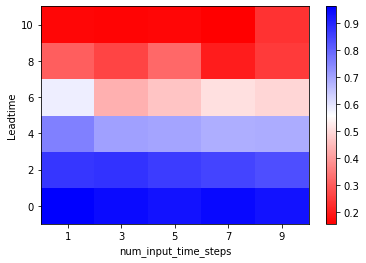

In [165]:
plt.pcolormesh(np.array(corr_collect).reshape(6,5),cmap='bwr_r')
plt.yticks(np.arange(6)+0.5, range(0,11,2))
plt.xticks(np.arange(5)+0.5, range(1,10,2))
plt.ylabel('Leadtime')
plt.xlabel('num_input_time_steps')
plt.colorbar()

# Exercise 8: Get the best ENSO forecasting algorithm!  (Tip: check out ensembling between algorithms and try hyperparameter tuning.)

Do deeper neural networks with more convolutional layers help?
Try changing the hyperparameters of the neural network

*   learning rate
*   the choice of optimizer
*   the size of the convolution filters
*   the number of convolution filters
*   the number of weights in the fully connected layers

Does adding a time series of gridded monthly temperature as your predictor help?

Ensemble predictions from multiple different algorithms! Try using traditional ML, artificial neural networks, and convolutional neural networks.

Recall from the previous notebook: models with many parameters (i.e. very deep neural networks or very deep decision trees) are more likely to have very low bias and very high variance: they will likely overfit!


We will have a friendly competition.  *Develop a Nino3.4 Forecasting system for a lead_time of 5 months?* Submit your results to the kaggle link: https://www.kaggle.com/c/ams2020mlworkshop 

Details of the kaggle competition: just like in the first code cell, we will test our code on data from 2007-01-01 to 2017-12-31.  The data loader is reproduced below!  There are 131 predictor/predictand pairs between these dates.  Therefore, your entry should be exactly 131 numbers!  

## Ultimate Submission Code

In [9]:
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   201  100   201    0     0   1069      0 --:--:-- --:--:-- --:--:--  1069
  Using cached pyrfr-0.8.0.tar.gz (293 kB)
  Created wheel for pyrfr: filename=pyrfr-0.8.0-cp37-cp37m-linux_x86_64.whl size=2553783 sha256=7a86f748738218292eeb7704eec9011c8c4bba84b54d0ae30eb64b7f3c3d563c
  Stored in directory: /home/jovyan/.cache/pip/wheels/6a/af/d2/7c55d43ff3594397822347432a0351f4c803aa135009ccd98e
Successfully built pyrfr
Processing /home/jovyan/.cache/pip/wheels/5f/69/3f/3b7cdc2ba27b40d34bc6b0bc05cc349ed5e979e5cb72992bd3/smac-0.12.2-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/e6/8e/c7/c338956a635caa3b3153cd8e49b183badb75230ecf19144dff/lazy_import-0.2.2-py2.py3-none-any.whl


In [16]:
!pip  install --user auto-sklearn

In [17]:
import autosklearn.regression

#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 3
lead_time = 1
#Extract the following slice of latitude
lat_slice = slice(10, -10)
#Extract the following slice of longitude
lon_slice = slice(360-170,360-120)
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'flatten', 
                      num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                      lon_slice=lon_slice)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time, 'observations', 'flatten', 
                    num_input_time_steps=num_input_time_steps, lat_slice=lat_slice,
                    lon_slice=lon_slice)
automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=120,
        per_run_time_limit=30,
        tmp_folder='tmp/autosklearn_regression_example_tmp',
        output_folder='tmp/autosklearn_regression_example_out',
    )
automl.fit(train_predictors, train_predictands, dataset_name='ENSO',
           feat_type=feature_types)

ModuleNotFoundError: No module named 'autosklearn'

In [ ]:
print(automl.show_models())
predictions = automl.predict(test_predictors)
print("R2 score:", sklearn.metrics.r2_score(test_predictands, predictions))

### sklearn traditional ML (flatten)

In [ ]:
for lat in range(-90,90,20):
    for lon in range(0,360,20):
        lat_slice = slice(lat+20, lat)
        lon_slice = slice(lon, lon+20)
        for n in range(1,5):
            test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time=5, dataset='observations', 
                    data_format='flatten', num_input_time_steps=3,
                    use_pca=True, n_components=n,
                    lat_slice=lat_slice, lon_slice=lon_slice)
            

In [ ]:
#Select the data parameters for your model(s)!
lead_time = 5
data_format = raise NotImplementedError("Select a data format for your kaggle entry!")
lat_slice = raise NotImplementedError("Select a lat slice for your kaggle entry!")
lon_slice = raise NotImplementedError("Select a lon slice for your kaggle entry!")
num_input_time_steps = 3 #Do not change this!
use_pca = raise NotImplementedError("You decide if you would like to use PCA on the input predictors!")
n_components = raise NotImplementedError("You decide how many principal components to use on the input predictors!")
train_predictors, train_predictands = """YOUR CODE HERE: assemble predictors predictands how you see fit"""

train_predictors, train_predictands = assemble_predictors_predictands('YOUR CHOICE OF START DATE',
                    'YOUR CHOICE OF END DATE', lead_time=5, dataset='observations', 
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components)
#Do not change the line below for your kaggle submission
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01',
                    '2017-12-31', lead_time=5, dataset='observations', 
                    data_format=data_format, num_input_time_steps=num_input_time_steps,
                    use_pca=use_pca, n_components=n_components)

#If using deep learning:
# create an ENSODataset and DataLoader
#object (see code cell in Exercise 1) and use the `train_network` method to 
#extract predictions!
train_dataset = ENSODataset(train_predictors, train_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)
trainloader = DataLoader(train_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
cnn_predictions, _, _ = train_network()


#If using regular traditional ML with sklearn:
sklearn_model = #choose sklearn model
sklearn_model.fit(train_predictors,train_predictands)

sklearn_predictions = sklearn_model.predict(test_predictors)


#Ensemble predictions from multiple algorithms
#(i.e. take the average of predictions from multiple algorithms!)
predictions = (cnn_predictions +sklearn_predictions)/2.0



In [ ]:
#TO GENERATE A kaggle READY SUBMISSION:
import pandas as pd
submission_df = pd.DataFrame()
submission_df['Id'] = np.arange(130)
submission_df['Predicted'] = np.random.uniform(size=(130)) #replace with your predictions!
submission_df.to_csv('submission.csv',index=False)
from google.colab import files
files.download('submission.csv') 

## Tip when changing convolutional layers:

When you are changing the size of convolution filter windows, pay special attention to the comment starting with "ATTENTION EXERCISE 9" in the `CNN` class.  This is a  TOUGH part of designing neural networks, especially in climate data where data is of many different grids!!  And it automatically causes your code to break!

After the convolution layers, ["features"](https://deepai.org/machine-learning-glossary-and-terms/feature-extraction) have been extracted from the input image.  These features are not necessarily of the same dimension as the input, but these features are spatial (that is, they are of the shape (batch_size, num_input_channels, lat, lon).  

We want to map these features to the value of the Niño3.4 index.  To do this mapping, we need a Linear (fully connected layer).  This Linear layer performs a matrix multiplication between the extracted features from the convolution layers and the weights of the linear layer.  Thus, it must know the dimensions of the features ahead of time.

The "Print" layer prints out the dimension of the extracted features.  Thus, we can design the linear layer accordingly, since the Linear layer requires the dimension of the input in order to perform a matrix multiplication.  

Of course, it is also possible and preferred to calculate the dimensions of the extracted features, using the formulas [here](http://cs231n.github.io/convolutional-networks/#conv).  Using the "Print" layer is a hacky get-around!

# EXERCISE 9: Do not just forecast ENSO.  Use this toolkit to forecast seasonal temperatures on land!

The machine learning framework we have developed here relies on assembling a set of predictors and predictands.  Thus far, the predictors have been surface temperature and the predictands have been the Nino3.4 index.  However, what if we wanted to forecast something else on seasonal time scales?  


In this section, please adjust the `assemble_predictors_predictands` methods to take into account ARBITRARY locations as predictors.  By default, the method uses the Nino3.4 Index.  Then, train a model to forecast temperature at regions you are interested in.

For the purpose of comparison, we will ask everyone to forecast temperature at these location at a lead time of 3 months:



*  Akron, Ohio: lat = 41, lon = 360-81
*  Mexico City, Mexico: lat = 19, lon = 360-99
*  Lima, Peru: lat = -12, 360-77


How does the forecasting performance change at these regions?

Feel free to test on any other regions you like and submit those as well.  We would love to the performance of your models at other regions as well.

In [6]:
"""Your CODE HERE"""

'Your CODE HERE'

# Practice EXERCISE 10: CNNs+LSTMs

If num_input_time_steps is greater than 1, then the model uses a time series of inputs to make its prediction.  Recurrent neural networks (with Long Short Term Memory (LSTM) architectures) are used for this purpose!  

**GOAL OF THIS EXERCISE:** Design a recurrent neural network (called an LSTM) for ENSO forecasting. For each input time step, 

1.   a CNN should extract features
2.   These features should then be fed into an LSTM

(The LSTM decides which parts of the features to remember and which to forget)

After the last input time step is fed into the LSTM, the model should use fully connected layers to make a forecast.

In [8]:
class CNNandLSTM(nn.Module):
  """YOUR CODE HERE"""

In [ ]:
class CNNandLSTM(nn.Module):
  """YOUR CODE HERE"""

# Practice Exercise 11: How does the quantity of data affect the performance of a machine learning algorithm?  

In the coding cell below, repeat the above training process for different length training datasets and test datasets!

**GOAL OF THIS EXERCISE**: train 6 neural networks: one on 10 years of data, one on 20 years of data, one on 30 years of data,...,one on 60 years of data.  Make a line plot showing the performance of each of these neural networks.  The X axis of the plot is the number of years of training data, and the y axis is the Pearson R value on the test set.

^Repeat the above for a traditional ML algorithm (e.g. linear regression) of your choice.

**Disclaimer:** this code cell involves training multiple neural networks.  I recommend working on this code cell after finishing the other parts of the hackathon.  Because of Google Colab [policy](https://research.google.com/colaboratory/faq.html), the availability of GPUs varies: sometimes, training multiple neural networks takes a liong time due to the availability of resources.

In [ ]:
for num_years in range(10,71,10):
  """YOUR CODE HERE"""
  pass